Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import numpy as np
import tensorflow as tf
print tf.__version__
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import pprint
import copy
from ggplot import *
import re

0.6.0


In [2]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects.lib import grid
from rpy2.robjects.lib import ggplot2
import rpy2.robjects.pandas2ri

First reload the data we generated in _notmist.ipynb_.

In [3]:
pickle_file = 'data/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  glbObsFitX = save['train_dataset']
  glbObsFitY = save['train_labels']
  glbObsOOBX = save['valid_dataset']
  glbObsOOBY = save['valid_labels']
  glbObsNewX = save['test_dataset']
  glbObsNewY = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', glbObsFitX.shape, glbObsFitY.shape)
  print('Validation set', glbObsOOBX.shape, glbObsOOBY.shape)
  print('Test set', glbObsNewX.shape, glbObsNewY.shape)

('Training set', (519114, 28, 28), (519114,))
('Validation set', (10000, 28, 28), (10000,))
('Test set', (18724, 28, 28), (18724,))


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
glbObsFitX, glbObsFitY = reformat(glbObsFitX, glbObsFitY)
glbObsOOBX, glbObsOOBY = reformat(glbObsOOBX, glbObsOOBY)
glbObsNewX, glbObsNewY = reformat(glbObsNewX, glbObsNewY)
print('Fit set', glbObsFitX.shape, glbObsFitY.shape)
print('OOB set', glbObsOOBX.shape, glbObsOOBY.shape)
print('New set', glbObsNewX.shape, glbObsNewY.shape)

('Fit set', (519114, 784), (519114, 10))
('OOB set', (10000, 784), (10000, 10))
('New set', (18724, 784), (18724, 10))


In [5]:
pickle_file = '3_regularization_glbMdlDf.pickle'
glbMdlDf = pd.read_pickle(pickle_file)
print(glbMdlDf[['OOBAccuracy', 'tfSsnLoss']])

                                                               OOBAccuracy  \
num_steps learnDecayRate l2Penalty1 nRELUs kpRELUs l2Penalty3                
3001      1.00           0.0010     1      1.0     0.00001          0.1730   
                         0.0100     1      1.0     0.00000          0.1857   
                                                   0.00010          0.1869   
                         0.0000     1      1.0     0.00001          0.1878   
                                                   0.00010          0.1938   
                         0.0001     1      1.0     0.00001          0.2016   
                         0.0010     1      1.0     0.00000          0.2071   
                                                   0.01000          0.2089   
                         0.0000     1      1.0     0.01000          0.2237   
                         0.0001     1      1.0     0.00000          0.2237   
                         0.0000     1      1.0     0.00000      

In [6]:
#savMdlDf = copy.copy(glbMdlDf)
savMdlDf = glbMdlDf.copy()

In [7]:
def accuracy(predictions, labels):
  return (1.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compue the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

#### Logistic SGD

In [8]:
batch_size = 128
num_steps = 3001

logisticL2NoneGraph = tf.Graph()
with logisticL2NoneGraph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tfObsFitX = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tfObsFitY = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tfObsOOBX = tf.constant(glbObsOOBX)
  tfObsNewX = tf.constant(glbObsNewX)
  
  # Variables.
  tfWgt1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]), name = 'tfWgt1')
    #tf.truncated_normal([image_size * image_size, thsRelu]), name = 'tfWgt1')
  #tfBss1 = tf.Variable(tf.zeros([thsRelu]), name = 'tfBss1')
  tfBss1 = tf.Variable(tf.zeros([num_labels]), name = 'tfBss1')
#   tfWgt2 = tf.Variable(
#     tf.truncated_normal([thsRelu, num_labels]), name = 'tfWgt2')
#   tfBss2 = tf.Variable(tf.zeros([num_labels]), name = 'tfBss2')
  print(tfWgt1.initialized_value())
  print(tfBss1.initialized_value())
  #print(relus.initialized_value())
#   print(tfWgt2.initialized_value())
#   print(tfBss2.initialized_value())
     
  # Training computation.
  tfLayer1 = tf.matmul(tfObsFitX, tfWgt1) + tfBss1
#   layer2 = tf.nn.relu(layer1)
#   layer3 = tf.matmul(layer2, tfWgt2) + tfBss2
  tfLoss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(tfLayer1, tfObsFitY))
    #tf.nn.softmax_cross_entropy_with_logits(layer3, tfObsFitY))    
  
  # Optimizer.
  tfOptimizer = tf.train.GradientDescentOptimizer(0.5).minimize(tfLoss)
  
  # Predictions for the training, validation, and test data.
  tfObsFitYP = tf.nn.softmax(tfLayer1)
  tfObsOOBYP = tf.nn.softmax(tf.matmul(tfObsOOBX, tfWgt1) + tfBss1)
  tfObsNewYP = tf.nn.softmax(tf.matmul(tfObsNewX, tfWgt1) + tfBss1)

#   glbObsFitYP = tf.nn.softmax(layer3)
#   glbObsOOBYP = tf.nn.softmax(
#     tf.matmul(tf.nn.relu(tf.matmul(tfObsOOBX, tfWgt1) + tfBss1), tfWgt2) + tfBss2)
#   glbObsNewYP = tf.nn.softmax(
#     tf.matmul(tf.nn.relu(tf.matmul(tfObsNewX, tfWgt1) + tfBss1), tfWgt2) + tfBss2)

with tf.Session(graph = logisticL2NoneGraph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (glbObsFitY.shape[0] - batch_size)
    # Generate a minibatch.
    obsBthX = glbObsFitX[offset:(offset + batch_size), :]
    obsBthY = glbObsFitY[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tfObsFitX : obsBthX, tfObsFitY : obsBthY}
    tfSsnOptimizer, tfSsnLoss, tfSsnObsFitYP = session.run(
      [tfOptimizer, tfLoss, tfObsFitYP], feed_dict = feed_dict)
    if (step % 500 == 0):
      print("obsFitBth loss at step %4d: %.4e" % (step, tfSsnLoss))
      print("obsFitBth accuracy: %0.4f" % accuracy(tfSsnObsFitYP,        obsBthY))
      print("obsOOB    accuracy: %0.4f" % accuracy(tfObsOOBYP.eval(), glbObsOOBY))
  
  print("Optimized")
  print("  tfWgt1:")
  pprint.pprint(tfWgt1.eval())
  print("  tfBss1:")
  pprint.pprint(tfBss1.eval())
  logisticL2NoneOOBAccuracy =               accuracy(tfObsOOBYP.eval(), glbObsOOBY)
  print(    "obsOOB    accuracy: %0.4f" % logisticL2NoneOOBAccuracy)
  logisticL2NoneNewAccuracy =               accuracy(tfObsNewYP.eval(), glbObsNewY)
  print(    "obsNew    accuracy: %0.4f" % logisticL2NoneNewAccuracy)

Tensor("Identity:0", shape=TensorShape([Dimension(784), Dimension(10)]), dtype=float32)
Tensor("Identity_1:0", shape=TensorShape([Dimension(10)]), dtype=float32)
Initialized
obsFitBth loss at step    0: 1.8438e+01
obsFitBth accuracy: 0.1250
obsOOB    accuracy: 0.1401
obsFitBth loss at step  500: 1.7761e+00
obsFitBth accuracy: 0.7422
obsOOB    accuracy: 0.7543
obsFitBth loss at step 1000: 1.3668e+00
obsFitBth accuracy: 0.7266
obsOOB    accuracy: 0.7649
obsFitBth loss at step 1500: 1.3551e+00
obsFitBth accuracy: 0.7500
obsOOB    accuracy: 0.7637
obsFitBth loss at step 2000: 1.2497e+00
obsFitBth accuracy: 0.7969
obsOOB    accuracy: 0.7721
obsFitBth loss at step 2500: 8.8139e-01
obsFitBth accuracy: 0.7891
obsOOB    accuracy: 0.7753
obsFitBth loss at step 3000: 1.0677e+00
obsFitBth accuracy: 0.7578
obsOOB    accuracy: 0.7793
Optimized
  tfWgt1:
array([[ 0.44353053, -0.08017071, -0.52482355, ..., -0.53146821,
        -0.33266309,  0.37546527],
       [ 0.19955951, -0.21577017, -1.21545541, .

obsOOB    accuracy: 0.7793
obsNew    accuracy: 0.8565


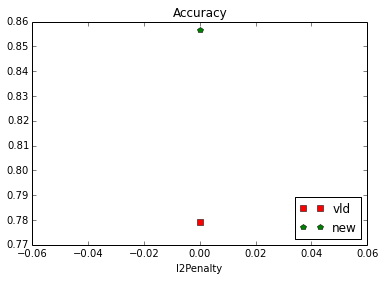

In [9]:
print(    "obsOOB    accuracy: %0.4f" % logisticL2NoneOOBAccuracy)
print(    "obsNew    accuracy: %0.4f" % logisticL2NoneNewAccuracy)
plt.figure()
plt.plot(0, logisticL2NoneOOBAccuracy, 'rs', label = 'vld')
plt.plot(0, logisticL2NoneNewAccuracy, 'gp', label = 'new')
plt.legend(loc = 'lower right')
plt.title("Accuracy")
#plt.xscale('symlog', basex=2)
axes = plt.gca()
axes.set_xlabel('l2Penalty')
# axes.set_xlim([mdlDF['l1_penalty'][mdlDF['RSS.vld'].argmin()] / 10 ** 2, \
#                mdlDF['l1_penalty'][mdlDF['RSS.vld'].argmin()] * 10 ** 2])
# axes.set_ylim([0, mdlDF['RSS.vld'].min() * 1.5])
plt.show()

#### Logistic SGD with L2 penalty

In [10]:
#glbMdlDf = pd.DataFrame()

In [116]:
# store matrices as a string separated by semicolons & use np.matrix to convert from string
def fitMdl(l2Penalty1, nRELUs):
    print(' ')
    print('fitMdl: l2Penalty1:%0.4e; nRELUs:%d' % (l2Penalty1, nRELUs))
    
    tf.set_random_seed(123)
    #nRELUs = 0
    #l2Penalty1 = 0
    batch_size = 128
    num_steps = 3001

    mdlDf = pd.DataFrame({'l2Penalty1': [l2Penalty1], 'nRELUs': [nRELUs]})
    mdlDf.ix[0, 'tfGraph'] = tf.Graph()
    with mdlDf.ix[0, 'tfGraph'].as_default():

      # Input data. For the training data, we use a placeholder that will be fed
      # at run time with a training minibatch.
      tfObsFitX = tf.placeholder(tf.float32,
                                        shape=(batch_size, image_size * image_size))
      tfObsFitY = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
      tfObsOOBX = tf.constant(glbObsOOBX)
      tfObsNewX = tf.constant(glbObsNewX)

      # Variables.
      tfWgt1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, num_labels]), name = 'tfWgt1')
        #tf.truncated_normal([image_size * image_size, thsRelu]), name = 'tfWgt1')
      #tfBss1 = tf.Variable(tf.zeros([thsRelu]), name = 'tfBss1')
      tfBss1 = tf.Variable(tf.zeros([num_labels]), name = 'tfBss1')
    #   tfWgt2 = tf.Variable(
    #     tf.truncated_normal([thsRelu, num_labels]), name = 'tfWgt2')
    #   tfBss2 = tf.Variable(tf.zeros([num_labels]), name = 'tfBss2')
      print(tfWgt1.initialized_value())
      print(tfBss1.initialized_value())
      #print(relus.initialized_value())
    #   print(tfWgt2.initialized_value())
    #   print(tfBss2.initialized_value())

      # Training computation.
      tfLayer1 = tf.matmul(tfObsFitX, tfWgt1) + tfBss1
    #   layer2 = tf.nn.relu(layer1)
    #   layer3 = tf.matmul(layer2, tfWgt2) + tfBss2
      tfLoss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(tfLayer1, tfObsFitY) + 
        l2Penalty1 * tf.nn.l2_loss(tfWgt1))
        #tf.nn.softmax_cross_entropy_with_logits(layer3, tfObsFitY))    

      # Optimizer.
      tfOptimizer = tf.train.GradientDescentOptimizer(0.5).minimize(tfLoss)

      # Predictions for the training, validation, and test data.
      tfObsFitYP = tf.nn.softmax(tfLayer1)
      tfObsOOBYP = tf.nn.softmax(tf.matmul(tfObsOOBX, tfWgt1) + tfBss1)
      tfObsNewYP = tf.nn.softmax(tf.matmul(tfObsNewX, tfWgt1) + tfBss1)

    #   glbObsFitYP = tf.nn.softmax(layer3)
    #   glbObsOOBYP = tf.nn.softmax(
    #     tf.matmul(tf.nn.relu(tf.matmul(tfObsOOBX, tfWgt1) + tfBss1), tfWgt2) + tfBss2)
    #   glbObsNewYP = tf.nn.softmax(
    #     tf.matmul(tf.nn.relu(tf.matmul(tfObsNewX, tfWgt1) + tfBss1), tfWgt2) + tfBss2)

    with tf.Session(graph = mdlDf.ix[0, 'tfGraph']) as session:
      tf.initialize_all_variables().run()
      print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (glbObsFitY.shape[0] - batch_size)
        # Generate a minibatch.
        obsBthX = glbObsFitX[offset:(offset + batch_size), :]
        obsBthY = glbObsFitY[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tfObsFitX : obsBthX, tfObsFitY : obsBthY}
        tfSsnOptimizer, tfSsnLoss, tfSsnObsFitYP = session.run(
          [tfOptimizer, tfLoss, tfObsFitYP], feed_dict = feed_dict)
        if (step % 500 == 0):
          print("obsFitBth loss at step %4d: %.4e" % (step, tfSsnLoss))
          print("obsFitBth accuracy: %0.4f" % accuracy(tfSsnObsFitYP,        obsBthY))
          print("obsOOB    accuracy: %0.4f" % accuracy(tfObsOOBYP.eval(), glbObsOOBY))

      print("Optimized")
      mdlDf.ix[0, 'tfWgt1'] = str(tfWgt1.eval().tolist())    
      print("  tfWgt1:")
      pprint.pprint(tfWgt1.eval())
      #print(type(tfBss1.eval()))
      mdlDf.ix[0, 'tfBss1'] = str(tfBss1.eval().tolist())
      print("  tfBss1:")
      pprint.pprint(tfBss1.eval())
      mdlDf.ix[0, 'tfSsnLoss'] = tfSsnLoss  
      mdlDf.ix[0, 'OOBAccuracy'] = accuracy(tfObsOOBYP.eval(), glbObsOOBY)
      print(    "obsOOB    accuracy: %0.4f" % mdlDf.ix[0, 'OOBAccuracy'])
      mdlDf.ix[0, 'NewAccuracy'] = accuracy(tfObsNewYP.eval(), glbObsNewY)
      print(    "obsNew    accuracy: %0.4f" % mdlDf.ix[0, 'NewAccuracy'])

    return(mdlDf)

In [12]:
# mdlDf = fitMdl(l2Penalty1 = l2Penalty1Search[1], nRELUs = 0)
print(glbMdlDf)
# print(type(glbMdlDf.l2Penalty1))
# print(glbMdlDf.l2Penalty1)
#print(glbMdlDf.l2Penalty1.isin([0]))
#print(glbMdlDf.l2Penalty1.isin([0]).any())

                              NewAccuracy  OOBAccuracy  l2Penalty1  \
l2Penalty1 nRELUs l2Penalty3                                         
0.0100     1      0              0.184149       0.1857      0.0100   
0.0010     1      0              0.216247       0.2071      0.0010   
0.0001     1      0              0.243965       0.2237      0.0001   
0.0000     1      0              0.236702       0.2279      0.0000   
0.1000     1      0              0.288560       0.2662      0.1000   
           2      0              0.364986       0.3393      0.1000   
0.0000     2      0              0.381542       0.3538      0.0000   
0.0001     2      0              0.448248       0.3970      0.0001   
0.0100     2      0              0.523713       0.4665      0.0100   
0.0010     2      0              0.536851       0.4923      0.0010   
1.0000     0      0              0.555971       0.5058      1.0000   
0.0001     4      0              0.669301       0.6038      0.0001   
0.0000     4      0 

In [13]:
# l2Penalty1Search = [0, 1e-04, 9e-04, 1e-03, 3e-03, 1e-02, 1e-01]
# for l2Penalty1 in l2Penalty1Search:
#     if (glbMdlDf.shape[0] == 0) or \
#        (not glbMdlDf.l2Penalty1.isin([l2Penalty1]).any()):
#         mdlDf = fitMdl(l2Penalty1, nRELUs)
#         glbMdlDf = glbMdlDf.append(mdlDf)
        
# glbMdlDf = (glbMdlDf
#             .set_index('l2Penalty1', drop = False)
#             .sort_values('OOBAccuracy')
#             )
# print(glbMdlDf)

In [15]:
def pltMdlDf(xscale = None):
    thsMdlDf = glbMdlDf.sort_values('l2Penalty1')
    plt.figure()
    lgndFeats = []
    plt.title("SGD Logistic Layer1")
    if (xscale != None):
        plt.xscale(xscale)

    ax = plt.gca()
    lgndFeats.append(ax.plot(thsMdlDf['l2Penalty1'], thsMdlDf['OOBAccuracy'], 'rs-', label = 'OOB'))
    lgndFeats.append(ax.plot(thsMdlDf['l2Penalty1'], thsMdlDf['NewAccuracy'], 'gp-', label = 'New'))
    #ax.xscale('symlog')
    ax.set_xlabel('l2Penalty1')
    ax.set_ylabel('Accuracy')
    # axes.set_xlim([mdlDF['l1_penalty'][mdlDF['RSS.vld'].argmin()] / 10 ** 2, \
    #                mdlDF['l1_penalty'][mdlDF['RSS.vld'].argmin()] * 10 ** 2])
    # axes.set_ylim([0, mdlDF['RSS.vld'].min() * 1.5])

    ax2 = ax.twinx()
    lgndFeats.append(ax2.plot(thsMdlDf['l2Penalty1'], thsMdlDf['tfSsnLoss'], 'bo-', label = 'Fit'))
    ax2.set_ylabel('tfSsnLoss')

    lgndFeatsSum = []
    for lgndIx in xrange(len(lgndFeats)):
        lgndFeatsSum += lgndFeats[lgndIx]
    ax.legend(lgndFeatsSum, [feat.get_label() for feat in lgndFeatsSum])
    plt.show()
    
# pltMdlDf(xscale = 'symlog')    
# pltMdlDf(xscale = 'log')    

#### Logistic with RELUs SGD

In [124]:
pickle_file = '3_regularization_glbMdlDf.pickle'
#glbMdlDf.iloc[:, 0:7].to_pickle(pickle_file)
# glbMdlDf.drop('tfGraph', axis = 1).to_pickle(pickle_file)
glbMdlDf = pd.read_pickle(pickle_file)
#print(glbMdlDf)

In [19]:
#print(glbMdlDf.columns[0:8])
#print(glbMdlDf.columns)
#print(glbMdlDf.shape[1] / 2)
#print(glbMdlDf.iloc[:, 0:(glbMdlDf.shape[1] / 2)])
#print(glbMdlDf.drop('tfGraph', axis = 1))

In [125]:
print(glbMdlDf.sort('OOBAccuracy')[['OOBAccuracy', 'tfSsnLoss']])

                              OOBAccuracy   tfSsnLoss
l2Penalty1 nRELUs l2Penalty3                         
0.0010     1      0.00001          0.1730    1.957925
0.0100     1      0.00000          0.1857    2.027550
                  0.00010          0.1869    2.010106
0.0000     1      0.00001          0.1878    2.126711
                  0.00010          0.1938    1.810957
0.0001     1      0.00001          0.2016    2.066144
0.0010     1      0.00000          0.2071    2.053993
                  0.01000          0.2089    1.925713
0.0000     1      0.01000          0.2237    2.110864
0.0001     1      0.00000          0.2237    1.995777
0.0000     1      0.00000          0.2279    2.070740
0.0001     1      0.01000          0.2291    2.351381
                  0.00010          0.2308    2.263467
                  0.00100          0.2326    2.058949
0.0000     1      0.00100          0.2331    1.940769
0.1000     1      0.00001          0.2376    1.949281
0.0100     1      0.00001   

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [117]:
# store matrices as a string separated by semicolons & use np.matrix to convert from string
def fitMdl(l2Penalty1, nRELUs, l2Penalty3):
    print(' ')
    print('fitMdl: l2Penalty1:%0.4e; nRELUs:%d; l2Penalty3:%0.4e' % 
          (l2Penalty1, nRELUs, l2Penalty3))
    
    if (nRELUs == 0) and (l2Penalty3 > 0):
        l2Penalty3 = 0
        print('  nRELUs == 0 overrides l2Penalty3 > 0 spec')
    
    tf.set_random_seed(123)
    #l2Penalty3 = 0
    #nRELUs = 0
    #l2Penalty1 = 0
    batch_size = 128
    num_steps = 3001

    mdlDf = pd.DataFrame(
        {'l2Penalty1': [l2Penalty1], 'nRELUs': [nRELUs], 'l2Penalty3': [l2Penalty3]})
    mdlDf['tfGraph'] = tf.Graph()
    with mdlDf['tfGraph'][0].as_default():

      # Input data. For the training data, we use a placeholder that will be fed
      # at run time with a training minibatch.
      tfObsFitX = tf.placeholder(tf.float32,
                                        shape=(batch_size, image_size * image_size))
      tfObsFitY = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
      tfObsOOBX = tf.constant(glbObsOOBX)
      tfObsNewX = tf.constant(glbObsNewX)

      # Variables.
      if (nRELUs == 0):
          tfWgt1 = tf.Variable(
            tf.truncated_normal([image_size * image_size, num_labels]), name = 'tfWgt1')
          tfBss1 = tf.Variable(tf.zeros([num_labels]), name = 'tfBss1')
          tfWgt3 = 0
          tfBss3 = 0
      else:  
          tfWgt1 = tf.Variable(
            tf.truncated_normal([image_size * image_size, nRELUs]    ), name = 'tfWgt1')
          tfBss1 = tf.Variable(tf.zeros([nRELUs]    ), name = 'tfBss1')
          tfWgt3 = tf.Variable(
            tf.truncated_normal([nRELUs, num_labels]), name = 'tfWgt3')
          tfBss3 = tf.Variable(tf.zeros([num_labels]), name = 'tfBss3')
        
      print(tfWgt1.initialized_value())
      print(tfBss1.initialized_value())
      if (nRELUs > 0):  
          print(tfWgt3.initialized_value())
          print(tfBss3.initialized_value())

      # Training computation.
      tfLayer1 = tf.matmul(tfObsFitX, tfWgt1) + tfBss1
      if (nRELUs == 0):  
          tfLayer3 = tfLayer1
      else:  
          tfLayer2 = tf.nn.relu(tfLayer1)
          tfLayer3 = tf.matmul(tfLayer2, tfWgt3) + tfBss3
        
      if (nRELUs == 0):          
          tfLoss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(tfLayer3, tfObsFitY))        
      else:          
          tfLoss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(tfLayer3, tfObsFitY) + 
                                                    l2Penalty1 * tf.nn.l2_loss(tfWgt1) + 
                                                    l2Penalty3 * tf.nn.l2_loss(tfWgt3))

      # Optimizer.
      tfOptimizer = tf.train.GradientDescentOptimizer(0.5).minimize(tfLoss)

      # Predictions for the training, validation, and test data.
      tfObsFitYP = tf.nn.softmax(tfLayer3)
      if (nRELUs == 0):
          tfObsOOBYP = tf.nn.softmax(tf.matmul(tfObsOOBX, tfWgt1) + tfBss1)            
          tfObsNewYP = tf.nn.softmax(tf.matmul(tfObsNewX, tfWgt1) + tfBss1)
      else:      
          tfObsOOBYP = tf.nn.softmax(
            tf.matmul(tf.nn.relu(tf.matmul(tfObsOOBX, tfWgt1) + tfBss1), tfWgt3) + tfBss3)        
          tfObsNewYP = tf.nn.softmax(
            tf.matmul(tf.nn.relu(tf.matmul(tfObsNewX, tfWgt1) + tfBss1), tfWgt3) + tfBss3)        

    with tf.Session(graph = mdlDf['tfGraph'][0]) as session:
      tf.initialize_all_variables().run()
      print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (glbObsFitY.shape[0] - batch_size)
        # Generate a minibatch.
        obsBthX = glbObsFitX[offset:(offset + batch_size), :]
        obsBthY = glbObsFitY[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tfObsFitX : obsBthX, tfObsFitY : obsBthY}
        tfSsnOptimizer, tfSsnLoss, tfSsnObsFitYP = session.run(
          [tfOptimizer, tfLoss, tfObsFitYP], feed_dict = feed_dict)
        if (step % 500 == 0):
          print("obsFitBth loss at step %4d: %.4e" % (step, tfSsnLoss))
          print("obsFitBth accuracy: %0.4f" % accuracy(tfSsnObsFitYP,        obsBthY))
          print("obsOOB    accuracy: %0.4f" % accuracy(tfObsOOBYP.eval(), glbObsOOBY))

      print("Optimized")
      mdlDf.ix[0, 'tfWgt1'] = str(tfWgt1.eval().tolist())    
      print("  tfWgt1:")
      pprint.pprint(tfWgt1.eval())
      #print(type(tfBss1.eval()))
      mdlDf.ix[0, 'tfBss1'] = str(tfBss1.eval().tolist())
      print("  tfBss1:")
      pprint.pprint(tfBss1.eval())
        
      if (nRELUs > 0):  
          mdlDf.ix[0, 'tfWgt3'] = str(tfWgt3.eval().tolist())    
          print("  tfWgt3:")
          pprint.pprint(tfWgt3.eval())
          mdlDf.ix[0, 'tfBss3'] = str(tfBss3.eval().tolist())
          print("  tfBss3:")
          pprint.pprint(tfBss3.eval())
        
      mdlDf.ix[0, 'tfSsnLoss'] = tfSsnLoss  
      mdlDf.ix[0, 'OOBAccuracy'] = accuracy(tfObsOOBYP.eval(), glbObsOOBY)
      print(    "obsOOB    accuracy: %0.4f" % mdlDf.ix[0, 'OOBAccuracy'])
      mdlDf.ix[0, 'NewAccuracy'] = accuracy(tfObsNewYP.eval(), glbObsNewY)
      print(    "obsNew    accuracy: %0.4f" % mdlDf.ix[0, 'NewAccuracy'])

    return(mdlDf)

In [126]:
l2Penalty1Search = [0, 1e-04, 1e-03, 1e-02]
nRELUsSearch     = [0] + [2 ** elm for elm in [0, 1, 8, 10]]
l2Penalty3Search = [0, 1e-04, 1e-03, 1e-02]
for l2Penalty1 in l2Penalty1Search:
    for nRELUs in nRELUsSearch:
        for l2Penalty3 in l2Penalty3Search:
            if (nRELUs == 0):
                l2Penalty3 = 0
                
            if (glbMdlDf.shape[0] == 0) or \
               (glbMdlDf[
                        (glbMdlDf.l2Penalty1 == l2Penalty1) & 
                        (glbMdlDf.nRELUs     == nRELUs    ) &
                        (glbMdlDf.l2Penalty3 == l2Penalty3)
                        ].shape[0] == 0):
#                     print('fitMdl: l2Penalty1:%0.4e; nRELUs:%d; l2Penalty3:%0.4e' % 
#                               (l2Penalty1, nRELUs, l2Penalty3))
                mdlDf = fitMdl(l2Penalty1, nRELUs, l2Penalty3)
                glbMdlDf = glbMdlDf.append(mdlDf)
        
glbMdlDf = (glbMdlDf
            .set_index(['l2Penalty1', 'nRELUs', 'l2Penalty3'], drop = False)
            .sort_values('OOBAccuracy')
            )
print(glbMdlDf.sort('OOBAccuracy'))

                              NewAccuracy  OOBAccuracy  l2Penalty1  \
l2Penalty1 nRELUs l2Penalty3                                         
0.0010     1      0.00001        0.177953       0.1730      0.0010   
0.0100     1      0.00000        0.184149       0.1857      0.0100   
                  0.00010        0.192160       0.1869      0.0100   
0.0000     1      0.00001        0.187246       0.1878      0.0000   
                  0.00010        0.208876       0.1938      0.0000   
0.0001     1      0.00001        0.207808       0.2016      0.0001   
0.0010     1      0.00000        0.216247       0.2071      0.0010   
                  0.01000        0.220840       0.2089      0.0010   
0.0000     1      0.01000        0.235260       0.2237      0.0000   
0.0001     1      0.00000        0.243965       0.2237      0.0001   
0.0000     1      0.00000        0.236702       0.2279      0.0000   
0.0001     1      0.01000        0.238891       0.2291      0.0001   
                  0.

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:24: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [21]:
#print([0] + [2 ** elm for elm in [0, 1]])
#print([0] + pow(2, [0, 1]))
# pickle_file = 'data/3_regularization_glbMdlDf.pickle'
# try:
#     f = open(pickle_file, 'wb')
#     save = {'glbMdlDf': glbMdlDf[['l2Penalty1', 'nRELUs', 'l2Penalty3', \
#                                          'tfSsnLoss', 'OOBAccuracy']]}
#     pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
#     f.close()
# except Exception as e:
#     print('Unable to save data to', pickle_file, ':', e)
#     raise

In [43]:
#print(glbMdlDf[glbMdlDf.l2Penalty1 == 0][['OOBAccuracy', 'tfSsnLoss', 'tfGraph']])

##### scale_x_log masks geom_hline

In [317]:
# pltMdlDf = glbMdlDf[glbMdlDf.l2Penalty1 != 0]
# print(ggplot(pltMdlDf, aes(x = 'l2Penalty1', y = 'tfSsnLoss', group = 'nRELUs')) + \
#     geom_line() + \
#     #geom_hline(glbMdlDf[glbMdlDf.l2Penalty1 == 0], aes(yintercept = 'tfSsnLoss')) + \
#     #geom_hline(aes(yintercept = 'tfSsnLoss')) + \
#     geom_hline(yintercept = 2.070740, color = 'blue') + \
#     facet_grid('nRELUs', 'l2Penalty3', scales = 'free_y') + \
#     #facet_grid(x = 'nRELUs', y = 'l2Penalty3') + \
#     #scale_x_log(base = 10) + \
#     scale_x_continuous(limits = (1e-05, None)) + \
#     scale_y_continuous(limits = (0, None))  + \
#     ggtitle('Logistic with RELUs SGD\n(Row: nRELUs, Col: l2Penalty3)'))

In [27]:
# convert to R dataframe
# mdlDict = {'l2Penalty1': robjects.FloatVector(glbMdlDf['l2Penalty1']),
#            'nRELUs'    : robjects.FloatVector(glbMdlDf['nRELUs'    ]),
#            'l2Penalty3': robjects.FloatVector(glbMdlDf['l2Penalty3']),
#            'tfSsnLoss' : robjects.FloatVector(glbMdlDf['tfSsnLoss' ])}
# glbMdlRDf = robjects.DataFrame(mdlDict)
# print glbMdlRDf

In [10]:
pltFn = robjects.r("""
    require(ggplot2)
    require(tidyr)
    
    function(df) {
        pltDf <- tidyr::gather(df, 'key', 'value', -l2Penalty1, -nRELUs, -l2Penalty3)
        #tfSsnLoss OOBAccuracy
        gp <- ggplot(pltDf, aes_string(x = 'l2Penalty1', y = 'value', group = 'nRELUs')) + 
            #geom_line(aes_string(color = 'nRELUs')) + 
            geom_line(aes(color = as.factor(nRELUs))) +             
            geom_hline(data = subset(pltDf, (l2Penalty1 == 0)), 
                        aes(yintercept = value, color = as.factor(nRELUs)), 
                        linetype = 'dashed') + 
            geom_point(data = pltDf[(pltDf$key == 'OOBAccuracy') & 
                                    (pltDf$value == max(df$OOBAccuracy)), ],
                        shape = 5, color = 'black', size = 3) +             
            scale_x_log10() + ylab('') +
            scale_linetype_identity(guide = "legend") + 
            #guides(linetype = "legend") + 
            facet_grid('key ~ l2Penalty3', labeller = label_both, scales = 'free_y') + 
            theme(legend.position = "bottom") 
            ggtitle('Logistic with RELUs SGD')
         
        ggsave('3_regularization_logisticSGD.png', plot = gp, width = 6.5, height = 5.5)
        #print(gp)
        #dev.off()
    }
""")

pltFn(glbMdlRDf2)
#raw_input()    
#grDevices.dev_off()

/usr/local/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: tidyr

  res = super(Function, self).__call__(*new_args, **new_kwargs)


rpy2.rinterface.NULL

#### What do the RELUs identify ?

In [85]:
import re

In [127]:
print(re.compile('[\[,\]]'))
#print(re.compile('[\[,\]]').split(glbMdlDf.ix[bstMdlIx, 'tfWgt1']))

In [91]:
# def myStr2Np1dArray(ndarrStr):
#     return(np.fromstring(ndarrStr.partition('[')[2].partition(']')[0], 
#                          dtype='float', sep = ','))

# ndarrStr = glbMdlDf.ix[bstMdlIx, 'tfBss1']
# ndarrStr = ndarrStr.partition('[')[2]
# ndarrStr = ndarrStr.partition(']')[0]
# bstMdlTfBss1 = np.fromstring(ndarrStr, dtype='float', sep = ',')

# def myStr2NpNdArray(ndarrStr):
#     print('ndarrStr[:80]:%s' % (ndarrStr[:80]))
#     print('ndarrStr.count:%s' % (ndarrStr.count(']')))    
#     print('ndarrStr.find:%s' % (ndarrStr.find(']')))
#     print('ndarrStr[:???]:%s' % (ndarrStr[86600:86700]))
#     #print('ndarrStr.split:%s' % (ndarrStr.split))    
#     #return(0)
#     return(np.fromstring(ndarrStr.partition('[')[2].partition(']')[0], 
#                          dtype='float', sep = ','))

# print(myStr2NpNdArray(glbMdlDf.ix[bstMdlIx, 'tfWgt1']))

In [24]:
def myStr2NpNdArray(ndarrStr):
    xprRe = re.compile('[\[\]]')
    oneDArr = np.fromstring(xprRe.sub('', ndarrStr), dtype='float', sep = ',')
    if   (ndarrStr[:3] == '[[['):
        raise AssertionError("3-D array conversion not implemented yet")
    elif (ndarrStr[:2] == '[['):
        dim1 = (len(xprRe.findall(ndarrStr)) - 2) / 2;
        dim2 = oneDArr.shape[0] / dim1;
        #print("2-D Array: dim1:%d; dim2:%d" % (dim1, dim2))
        retArr = np.resize(oneDArr, (dim1, dim2))
    else:    
        retArr = oneDArr
    
    return(retArr)

# bstMdlTfBss1 = myStr2NpNdArray(glbMdlDf.ix[bstMdlIx, 'tfBss1'])
# print('\n  type(bstMdlTfBss1): type:%s; shape:%s' % (type(bstMdlTfBss1), bstMdlTfBss1.shape))
# print('\n  bstMdlTfBss1[:5]')
# print(bstMdlTfBss1[:5])

# bstMdlTfWgt1 = myStr2NpNdArray(glbMdlDf.ix[bstMdlIx, 'tfWgt1'])
# print('\n  type(bstMdlTfWgt1): type:%s; shape:%s' % (type(bstMdlTfWgt1), bstMdlTfWgt1.shape))
# print('\n  bstMdlTfWgt1[:5]')
# print(bstMdlTfWgt1[:5])

# print(myStr2NpNdArray('[[[1, 2]]]'))

In [7]:
# Id "best" model
bstMdlIx = glbMdlDf['OOBAccuracy'].argmax()
print('Best Model: %s', bstMdlIx)
print(glbMdlDf.ix[bstMdlIx, ])

('Best Model: %s', (3001, 0.001, 4096, 0.001))
                                        NewAccuracy  OOBAccuracy  l2Penalty1  \
num_steps l2Penalty1 nRELUs l2Penalty3                                         
3001      0.001      4096   0.001          0.933187       0.8721       0.001   

                                        l2Penalty3  nRELUs  num_steps  \
num_steps l2Penalty1 nRELUs l2Penalty3                                  
3001      0.001      4096   0.001            0.001    4096       3001   

                                                                                   tfBss1  \
num_steps l2Penalty1 nRELUs l2Penalty3                                                      
3001      0.001      4096   0.001       [-2.1031672954559326, -1.5412038564682007, -1....   

                                                                                   tfBss3  \
num_steps l2Penalty1 nRELUs l2Penalty3                                                      
3001      0.001      4096 

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [25]:
print("\n  glbMdlDf.ix[bstMdlIx, 'tfBss1'][:80]")
print(glbMdlDf.ix[bstMdlIx, 'tfBss1'][:80])
bstMdlTfBss1 = np.matrix(myStr2NpNdArray(glbMdlDf.ix[bstMdlIx, 'tfBss1']))
print('\n  type(bstMdlTfBss1): type:%s; shape:%s' % (type(bstMdlTfBss1), bstMdlTfBss1.shape))
print('\n  bstMdlTfBss1[:5]')
print(bstMdlTfBss1[:5])

print("\n  glbMdlDf.ix[bstMdlIx, 'tfWgt1'][:80]")
print(glbMdlDf.ix[bstMdlIx, 'tfWgt1'][:80])
bstMdlTfWgt1 = np.matrix(myStr2NpNdArray(glbMdlDf.ix[bstMdlIx, 'tfWgt1']))
print('\n  type(bstMdlTfWgt1): type:%s; shape:%s' % (type(bstMdlTfWgt1), bstMdlTfWgt1.shape))
print('\n  bstMdlTfWgt1[:5, :5]')
print(bstMdlTfWgt1[:5, :5])

('Best Model: %s', (0.001, 4096, 0.001))
                              NewAccuracy  OOBAccuracy  l2Penalty1  \
l2Penalty1 nRELUs l2Penalty3                                         
0.001      4096   0.001          0.933187       0.8721       0.001   

                              l2Penalty3  nRELUs  \
l2Penalty1 nRELUs l2Penalty3                       
0.001      4096   0.001            0.001    4096   

                                                                         tfBss1  \
l2Penalty1 nRELUs l2Penalty3                                                      
0.001      4096   0.001       [-2.1031672954559326, -1.5412038564682007, -1....   

                                                                         tfBss3  \
l2Penalty1 nRELUs l2Penalty3                                                      
0.001      4096   0.001       [-0.0855427011847496, 0.07413285970687866, -0....   

                              tfSsnLoss  \
l2Penalty1 nRELUs l2Penalty3              
0.001

In [26]:
#print('glbObsOOBX:     type:%s; shape:%s' % (type(glbObsOOBX)    , glbObsOOBX.shape    ))
glbObsOOBXMtrx = np.matrix(glbObsOOBX)
print('glbObsOOBXMtrx: type:%s; shape:%s' % (type(glbObsOOBXMtrx), glbObsOOBXMtrx.shape))

glbObsOOBXMtrx: type:<class 'numpy.matrixlib.defmatrix.matrix'>; shape:(10000, 784)


In [135]:
# glbObsOOBLyr1 = glbObsOOBXMtrx * bstMdlTfWgt1
# print(glbObsOOBLyr1[:5, :5])
glbObsOOBLyr1 = glbObsOOBXMtrx * bstMdlTfWgt1 + bstMdlTfBss1
print('glbObsOOBLyr1:  type:%s; shape:%s' % (type(glbObsOOBLyr1) , glbObsOOBLyr1.shape ))
print(glbObsOOBLyr1[:5, :5])


glbObsOOBLyr1:  type:<class 'numpy.matrixlib.defmatrix.matrix'>; shape:(10000, 4096)
[[-1.14369866 -2.20352264 -2.31193209 -2.9805195  -3.0636093 ]
 [-1.64372453  3.51640705  1.84838941  3.7227065   1.57096168]
 [ 0.19112972 -2.11489056 -2.23005648 -1.91418869 -2.10399684]
 [-0.83139349 -0.47281481  2.35206063 -0.15216174 -0.20024453]
 [-1.09156926 -4.32217617 -1.37657968 -5.28914935 -2.37021992]]
[[-3.24686596 -3.74472649 -3.84176803 -4.65680799 -4.54277592]
 [-3.74689183  1.97520319  0.31855347  2.04641802  0.09179505]
 [-1.91203758 -3.65609442 -3.75989242 -3.59047717 -3.58316347]
 [-2.93456078 -2.01401867  0.82222469 -1.82845023 -1.67941116]
 [-3.19473656 -5.86338003 -2.90641562 -6.96543784 -3.84938655]]


In [149]:
def relu(x):
    if x > 0: 
        return(x)
    else:
        return(0)
    
print(relu(-1.2))
print(relu(0.2))
print(relu(1.2))

0
0.2
1.2


In [152]:
reluFn = np.vectorize(relu, otypes=[np.float])
print(reluFn([[-2.2, -1.1, 0.1, 1.1, 2.1], 
              [-3.3, -4.4, 0.2, 3.3, 4.4]]))

[[ 0.   0.   0.1  1.1  2.1]
 [ 0.   0.   0.2  3.3  4.4]]


In [154]:
#glbObsOOBLyr2 = np.empty_like(glbObsOOBLyr1)
glbObsOOBLyr2 = reluFn(glbObsOOBLyr1)
print(glbObsOOBLyr2[:5, :5])
print('glbObsOOBLyr2:  type:%s; shape:%s' % (type(glbObsOOBLyr2) , glbObsOOBLyr2.shape ))

[[ 0.          0.          0.          0.          0.        ]
 [ 0.          1.97520319  0.31855347  2.04641802  0.09179505]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.82222469  0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]]
glbObsOOBLyr2:  type:<class 'numpy.matrixlib.defmatrix.matrix'>; shape:(10000, 4096)


In [156]:
print("\n  glbMdlDf.ix[bstMdlIx, 'tfBss3'][:80]")
print(glbMdlDf.ix[bstMdlIx, 'tfBss3'][:80])
bstMdlTfBss3 = np.matrix(myStr2NpNdArray(glbMdlDf.ix[bstMdlIx, 'tfBss3']))
print('\n  type(bstMdlTfBss3): type:%s; shape:%s' % (type(bstMdlTfBss3), bstMdlTfBss3.shape))
print('\n  bstMdlTfBss3[:5]')
print(bstMdlTfBss3[:5])

print("\n  glbMdlDf.ix[bstMdlIx, 'tfWgt3'][:80]")
print(glbMdlDf.ix[bstMdlIx, 'tfWgt3'][:80])
bstMdlTfWgt3 = np.matrix(myStr2NpNdArray(glbMdlDf.ix[bstMdlIx, 'tfWgt3']))
print('\n  type(bstMdlTfWgt3): type:%s; shape:%s' % (type(bstMdlTfWgt3), bstMdlTfWgt3.shape))
print('\n  bstMdlTfWgt3[:5, :5]')
print(bstMdlTfWgt3[:5, :5])


  glbMdlDf.ix[bstMdlIx, 'tfBss3'][:80]
[-0.0855427011847496, 0.07413285970687866, -0.05699431523680687, -0.140033990144

  type(bstMdlTfBss3): type:<class 'numpy.matrixlib.defmatrix.matrix'>; shape:(1, 10)

  bstMdlTfBss3[:5]
[[-0.0855427   0.07413286 -0.05699432 -0.14003399  0.24096292 -0.26592246
   0.17225954 -0.24864343  0.34162956 -0.03184687]]

  glbMdlDf.ix[bstMdlIx, 'tfWgt3'][:80]
[[0.03512309864163399, 0.2600645422935486, 0.072090744972229, -4.16932234656997e

  type(bstMdlTfWgt3): type:<class 'numpy.matrixlib.defmatrix.matrix'>; shape:(4096, 10)

  bstMdlTfWgt3[:5, :5]
[[  3.51230986e-02   2.60064542e-01   7.20907450e-02  -4.16932235e-05
    1.63169488e-01]
 [ -3.65143195e-02  -8.28644261e-02  -1.66182593e-01  -1.61521870e-03
   -1.33335575e-01]
 [  7.45972022e-02   1.01473741e-01   7.81635195e-02   7.21925721e-02
   -6.74894601e-02]
 [  2.62810349e-01   7.55957663e-02   6.78601265e-02   9.32730734e-02
    1.87216729e-01]
 [  9.43129659e-02   2.96471398e-02  -1.18146077e-01 

In [161]:
glbObsOOBLyr3 = glbObsOOBLyr2 * bstMdlTfWgt3 + bstMdlTfBss3
print('glbObsOOBLyr3:  type:%s; shape:%s' % (type(glbObsOOBLyr3) , glbObsOOBLyr3.shape ))
print(glbObsOOBLyr3[:5])

glbObsOOBLyr3:  type:<class 'numpy.matrixlib.defmatrix.matrix'>; shape:(10000, 10)
[[ -0.65680586   0.53413425  -2.98666499  -2.34836399   0.70853368
   -1.68105986  -2.47336481   5.04214749  -1.68849589  -1.43629044]
 [  8.97270716   2.96682511 -13.61514106   2.69928685  -9.75613721
   -5.2687568    7.41715     70.79226825  16.17240904   3.62505503]
 [ -0.41893517  -1.21205839   2.61537779  -1.63280489   0.80668585
    0.3752744    6.64339771  -1.17087649  -1.53338369   0.10715954]
 [  4.41273105   0.22737316 -10.53028534  -6.8616546   -6.3192831
   -0.28671486  -5.75620792  20.70925199  -1.26412734   2.57788851]
 [  1.94689175   0.39094016  -6.31709621  -5.25792066  -2.92151795
   -3.92580109  -3.86565676  10.28021035  -3.28666502  -3.61194064]]


In [178]:
print(np.exp(glbObsOOBLyr3[:5]))
print(np.sum(np.exp(glbObsOOBLyr3[:5]), axis = 1))
glbObsOOBYSoftMax = np.exp(glbObsOOBLyr3) / np.sum(np.exp(glbObsOOBLyr3), axis = 1)
print(glbObsOOBYSoftMax[:5])
glbObsOOBYArgMax = np.argmax(glbObsOOBYSoftMax, axis = 1)
print(glbObsOOBYArgMax[:5])
glbObsOOBYP = np.zeros_like(glbObsOOBY)
for ix in xrange(glbObsOOBY.shape[0]):
    glbObsOOBYP[ix, glbObsOOBYArgMax[ix]] = 1.0
    
print(glbObsOOBYP[:5])
print( glbObsOOBY[:5])
print("glbObsOOBYP Accuracy:%0.4f vs. glbMdlDf.ix[bstMdlIx, 'OOBAccuracy']:%0.4f" % \
          (accuracy(glbObsOOBYP, glbObsOOBY), glbMdlDf.ix[bstMdlIx, 'OOBAccuracy']))

[[  5.18504868e-01   1.70597065e+00   5.04554260e-02   9.55253150e-02
    2.03101096e+00   1.86176550e-01   8.43007257e-02   1.54802094e+02
    1.84797271e-01   2.37808290e-01]
 [  7.88491848e+03   1.94301330e+01   1.22185415e-06   1.48691241e+01
    5.79379927e-05   5.15000910e-03   1.66428354e+03   5.55509466e+30
    1.05581543e+07   3.75267882e+01]
 [  6.57746833e-01   2.97584104e-01   1.36723806e+01   1.95380782e-01
    2.24047042e+00   1.45539072e+00   7.67698985e+02   3.10095027e-01
    2.15804216e-01   1.11311183e+00]
 [  8.24944529e+01   1.25529821e+00   2.67150003e-05   1.04717984e-03
    1.80123434e-03   7.50725761e-01   3.16308355e-03   9.86083892e+08
    2.82485704e-01   1.31693020e+01]
 [  7.00687461e+00   1.47837004e+00   1.80517777e-03   5.20611878e-03
    5.38518808e-02   1.97263280e-02   2.09491594e-02   2.91500047e+04
    3.73782976e-02   2.69993998e-02]]
[[  1.59896645e+02]
 [  5.55509466e+30]
 [  7.87856949e+02]
 [  9.86083990e+08]
 [  2.91586559e+04]]
[[  3.2427501

In [209]:
# True +ves vs. False +ves
glbObsOOBYDf = pd.DataFrame()
glbObsOOBYDf['imgIx'] = range(glbObsOOBY.shape[0])
glbObsOOBYDf['labelY'] = np.argmax(glbObsOOBY, axis = 1)
glbObsOOBYDf['labelYP'] = np.argmax(glbObsOOBYP, axis = 1)
glbObsOOBYDf['labelYPAcc'] = glbObsOOBYDf['labelY'] == glbObsOOBYDf['labelYP']
glbObsOOBYDf['labelYPProb'] = np.max(glbObsOOBYSoftMax, axis = 1)
print(glbObsOOBYDf['labelYPAcc'].value_counts())
print(glbObsOOBYDf[glbObsOOBYDf['labelYPAcc'] == True ][:5])
print(glbObsOOBYDf[glbObsOOBYDf['labelYPAcc'] == False][:5])
# psvObsOOB = np.zeros((glbObsOOBY.shape[0]))
# psvObsOOB[np.argmax(glbObsOOBYP, axis = 1) == np.argmax(glbObsOOBY, axis = 1)] = 1
# print(psvObsOOB[:5])
# print(psvObsOOB[psvObsOOB != 1][:5])
# tpvObsOOB = (psvObsOOB == 1.0)

True     8721
False    1279
Name: labelYPAcc, dtype: int64
   imgIx  labelY  labelYP labelYPAcc  labelYPProb
0      0       7        7       True     0.968138
1      1       7        7       True     1.000000
2      2       6        6       True     0.974414
3      3       7        7       True     1.000000
4      4       7        7       True     0.999703
    imgIx  labelY  labelYP labelYPAcc  labelYPProb
19     19       4        2      False     0.711911
23     23       8        9      False     0.174578
28     28       3        8      False     0.330631
35     35       8        6      False     0.357803
38     38       5        8      False     0.722231


In [210]:
# hghObsOOBYArgMax = np.argmax(glbObsOOBYSoftMax, axis = 0)
# print(hghObsOOBYArgMax[:5])
# print(hghObsOOBYArgMax.shape)


Label: 0
  imgIx: 5976
  glbObsOOBYDf.iloc[imgIx]:
imgIx          5976
labelY            0
labelYP           0
labelYPAcc     True
labelYPProb       1
Name: 5976, dtype: object
  glbObsOOBX[imgIx, :][:5]:[ 0.4137255   0.20588236  0.20980392  0.20588236  0.20588236]
  img2DArr[:5, :5]:
[[ 0.4137255   0.20588236  0.20980392  0.20588236  0.20588236]
 [ 0.19411765 -0.5        -0.5        -0.5        -0.5       ]
 [ 0.20980392 -0.49215686 -0.48431373 -0.49215686 -0.49215686]
 [ 0.20588236 -0.5        -0.49215686 -0.5        -0.5       ]
 [ 0.20588236 -0.5        -0.49215686 -0.5        -0.5       ]]


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


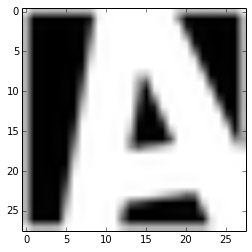

(1, 4096)


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


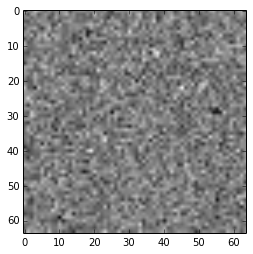

(1, 4096)


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:28: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


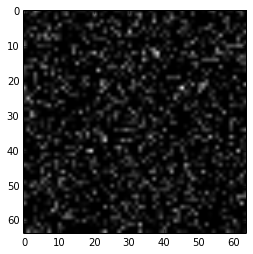

  imgIx: 5902
  glbObsOOBYDf.iloc[imgIx]:
imgIx           5902
labelY             9
labelYP            0
labelYPAcc     False
labelYPProb        1
Name: 5902, dtype: object
  glbObsOOBX[imgIx, :][:5]:[ 0.5  0.5  0.5  0.5  0.5]
  img2DArr[:5, :5]:
[[ 0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5        -0.1509804  -0.30784315 -0.30000001 -0.30784315]
 [ 0.5        -0.34705883 -0.5        -0.5        -0.5       ]
 [ 0.5        -0.30000001 -0.49215686 -0.48431373 -0.49215686]
 [ 0.5        -0.30784315 -0.5        -0.49215686 -0.5       ]]


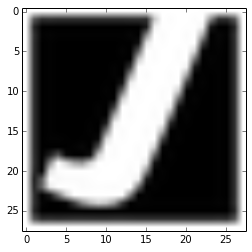

(1, 4096)


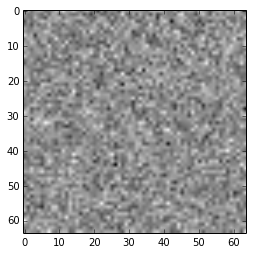

(1, 4096)


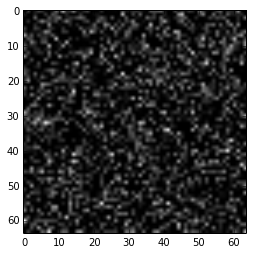


Label: 1
  imgIx: 8366
  glbObsOOBYDf.iloc[imgIx]:
imgIx          8366
labelY            1
labelYP           1
labelYPAcc     True
labelYPProb       1
Name: 8366, dtype: object
  glbObsOOBX[imgIx, :][:5]:[ 0.45294118  0.5         0.5         0.5         0.5       ]
  img2DArr[:5, :5]:
[[ 0.45294118  0.5         0.5         0.5         0.5       ]
 [ 0.47647059  0.42156863 -0.12352941 -0.1        -0.10392157]
 [ 0.49215686  0.36666667 -0.5        -0.49607843 -0.5       ]
 [ 0.49215686  0.36666667 -0.5        -0.48431373 -0.48823529]
 [ 0.49215686  0.36666667 -0.5        -0.49607843 -0.5       ]]


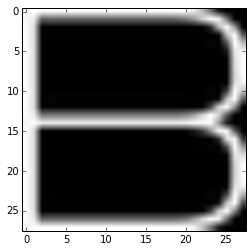

(1, 4096)


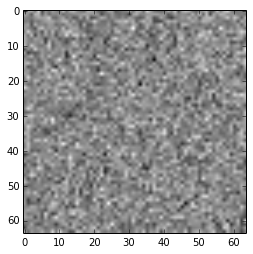

(1, 4096)


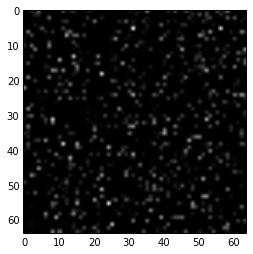

  imgIx: 3497
  glbObsOOBYDf.iloc[imgIx]:
imgIx              3497
labelY                3
labelYP               1
labelYPAcc        False
labelYPProb    0.994847
Name: 3497, dtype: object
  glbObsOOBX[imgIx, :][:5]:[ 0.5  0.5  0.5  0.5  0.5]
  img2DArr[:5, :5]:
[[ 0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5]]


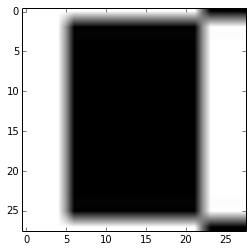

(1, 4096)


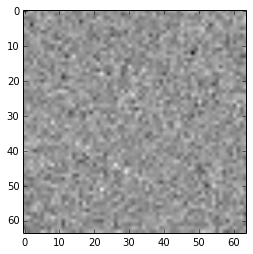

(1, 4096)


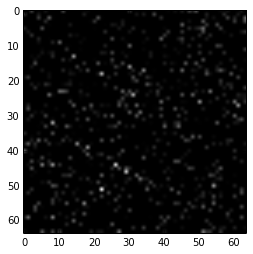


Label: 2
  imgIx: 2541
  glbObsOOBYDf.iloc[imgIx]:
imgIx          2541
labelY            2
labelYP           2
labelYPAcc     True
labelYPProb       1
Name: 2541, dtype: object
  glbObsOOBX[imgIx, :][:5]:[-0.5 -0.5 -0.5 -0.5 -0.5]
  img2DArr[:5, :5]:
[[-0.5        -0.5        -0.5        -0.5        -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.5       ]
 [-0.5        -0.5        -0.5        -0.49607843 -0.48823529]
 [-0.5        -0.5        -0.49607843 -0.49215686 -0.5       ]
 [-0.5        -0.49607843 -0.5        -0.48431373  0.0882353 ]]


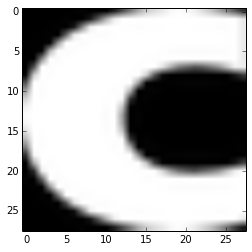

(1, 4096)


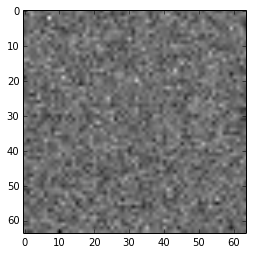

(1, 4096)


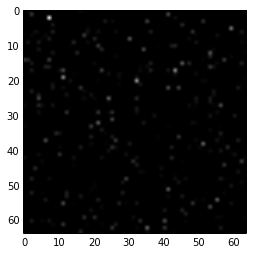

  imgIx: 1454
  glbObsOOBYDf.iloc[imgIx]:
imgIx              1454
labelY                1
labelYP               2
labelYPAcc        False
labelYPProb    0.998693
Name: 1454, dtype: object
  glbObsOOBX[imgIx, :][:5]:[ 0.5  0.5  0.5  0.5  0.5]
  img2DArr[:5, :5]:
[[ 0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5]]


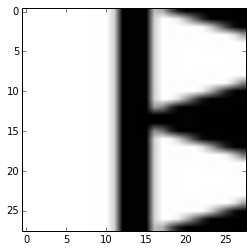

(1, 4096)


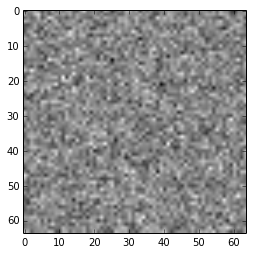

(1, 4096)


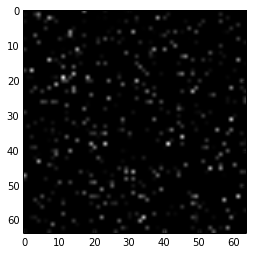


Label: 3
  imgIx: 8402
  glbObsOOBYDf.iloc[imgIx]:
imgIx          8402
labelY            3
labelYP           3
labelYPAcc     True
labelYPProb       1
Name: 8402, dtype: object
  glbObsOOBX[imgIx, :][:5]:[ 0.01764706  0.32352942  0.44117647  0.48823529  0.5       ]
  img2DArr[:5, :5]:
[[ 0.01764706  0.32352942  0.44117647  0.48823529  0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5       ]
 [ 0.49215686  0.49215686  0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.49215686]]


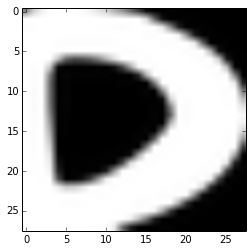

(1, 4096)


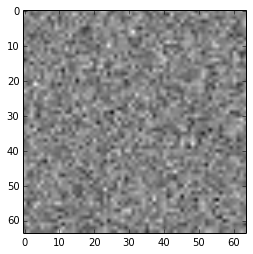

(1, 4096)


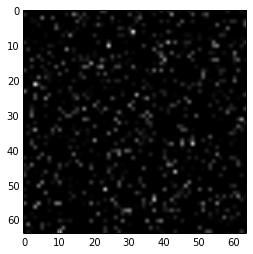

  imgIx: 5355
  glbObsOOBYDf.iloc[imgIx]:
imgIx              5355
labelY                7
labelYP               3
labelYPAcc        False
labelYPProb    0.987699
Name: 5355, dtype: object
  glbObsOOBX[imgIx, :][:5]:[-0.5        -0.5        -0.49607843 -0.5        -0.5       ]
  img2DArr[:5, :5]:
[[-0.5        -0.5        -0.49607843 -0.5        -0.5       ]
 [-0.5        -0.49215686 -0.5        -0.49607843 -0.49607843]
 [-0.49607843 -0.5        -0.48823529 -0.5        -0.5       ]
 [-0.5        -0.06078431  0.3509804   0.11176471 -0.42156863]
 [-0.17058824  0.5         0.37450981  0.5         0.25294119]]


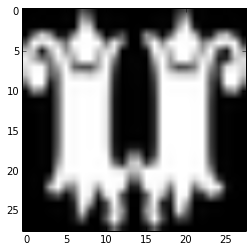

(1, 4096)


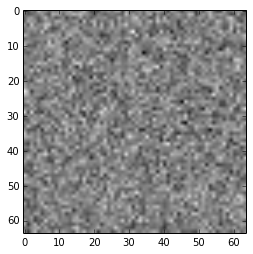

(1, 4096)


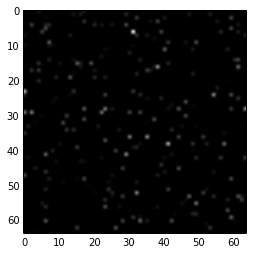


Label: 4
  imgIx: 5571
  glbObsOOBYDf.iloc[imgIx]:
imgIx          5571
labelY            4
labelYP           4
labelYPAcc     True
labelYPProb       1
Name: 5571, dtype: object
  glbObsOOBX[imgIx, :][:5]:[ 0.5  0.5  0.5  0.5  0.5]
  img2DArr[:5, :5]:
[[ 0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.44509804 -0.25686276 -0.20980392]
 [ 0.5         0.5         0.42156863 -0.5        -0.48431373]
 [ 0.5         0.5         0.42156863 -0.5        -0.47254902]
 [ 0.5         0.5         0.42156863 -0.5        -0.48431373]]


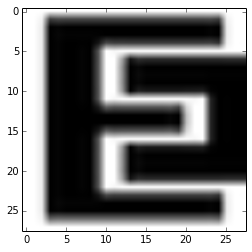

(1, 4096)


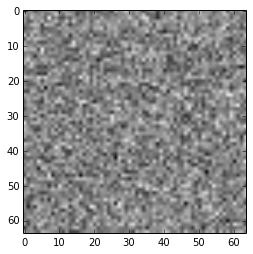

(1, 4096)


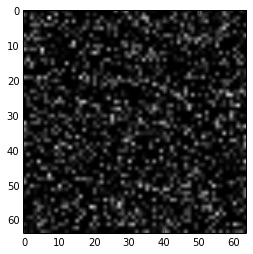

  imgIx: 3698
  glbObsOOBYDf.iloc[imgIx]:
imgIx              3698
labelY                7
labelYP               4
labelYPAcc        False
labelYPProb    0.998456
Name: 3698, dtype: object
  glbObsOOBX[imgIx, :][:5]:[ 0.34705883  0.40196079  0.39411765  0.39803922  0.39803922]
  img2DArr[:5, :5]:
[[ 0.34705883  0.40196079  0.39411765  0.39803922  0.39803922]
 [ 0.45686275  0.5         0.5         0.5         0.5       ]
 [ 0.43725491  0.49607843  0.49215686  0.49607843  0.49607843]
 [ 0.44117647  0.5         0.49607843  0.5         0.5       ]
 [ 0.4254902   0.48431373  0.48039216  0.48431373  0.48431373]]


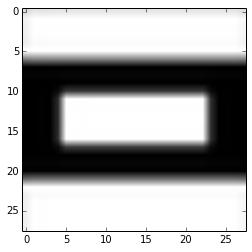

(1, 4096)


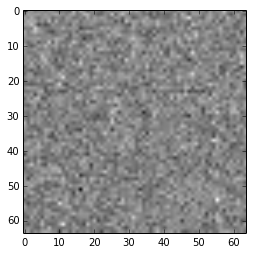

(1, 4096)


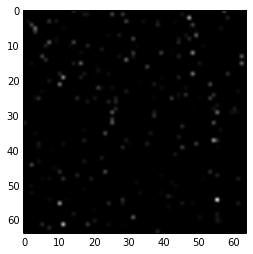


Label: 5
  imgIx: 3437
  glbObsOOBYDf.iloc[imgIx]:
imgIx          3437
labelY            5
labelYP           5
labelYPAcc     True
labelYPProb       1
Name: 3437, dtype: object
  glbObsOOBX[imgIx, :][:5]:[ 0.5         0.07254902 -0.5        -0.36666667  0.5       ]
  img2DArr[:5, :5]:
[[ 0.5         0.07254902 -0.5        -0.36666667  0.5       ]
 [ 0.5         0.07254902 -0.5        -0.36666667  0.5       ]
 [ 0.5         0.07254902 -0.5        -0.36666667  0.5       ]
 [ 0.5         0.07254902 -0.5        -0.36666667  0.5       ]
 [ 0.5         0.07254902 -0.5        -0.36666667  0.5       ]]


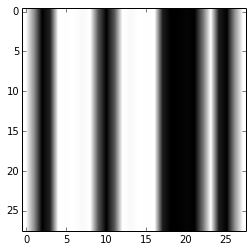

(1, 4096)


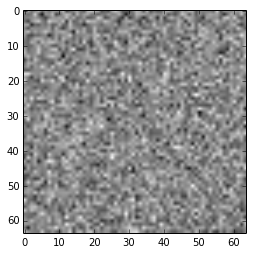

(1, 4096)


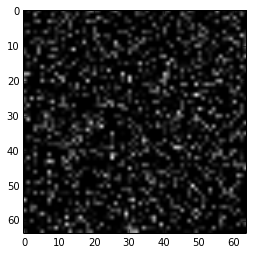

  imgIx: 5187
  glbObsOOBYDf.iloc[imgIx]:
imgIx           5187
labelY             6
labelYP            5
labelYPAcc     False
labelYPProb        1
Name: 5187, dtype: object
  glbObsOOBX[imgIx, :][:5]:[ 0.5  0.5  0.5  0.5  0.5]
  img2DArr[:5, :5]:
[[ 0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.5       ]
 [ 0.5         0.5         0.5         0.5         0.48823529]]


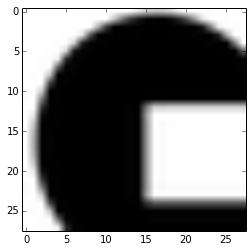

(1, 4096)


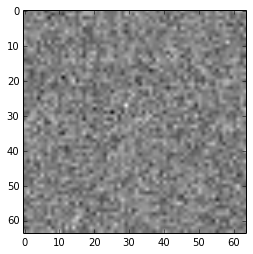

(1, 4096)


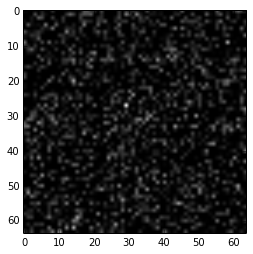


Label: 6
  imgIx: 3883
  glbObsOOBYDf.iloc[imgIx]:
imgIx          3883
labelY            6
labelYP           6
labelYPAcc     True
labelYPProb       1
Name: 3883, dtype: object
  glbObsOOBX[imgIx, :][:5]:[-0.5 -0.5 -0.5 -0.5 -0.5]
  img2DArr[:5, :5]:
[[-0.5        -0.5        -0.5        -0.5        -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.5       ]
 [-0.49607843 -0.49607843 -0.49607843 -0.49607843 -0.49607843]]


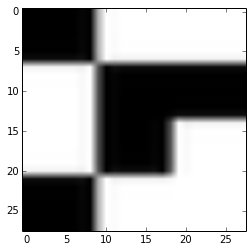

(1, 4096)


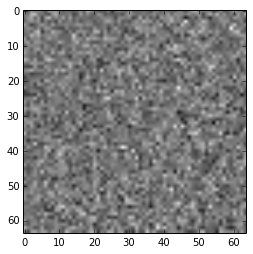

(1, 4096)


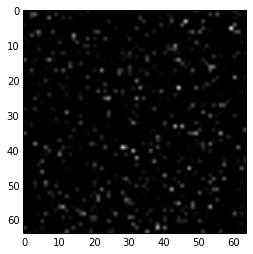

  imgIx: 9765
  glbObsOOBYDf.iloc[imgIx]:
imgIx              9765
labelY                5
labelYP               6
labelYPAcc        False
labelYPProb    0.998206
Name: 9765, dtype: object
  glbObsOOBX[imgIx, :][:5]:[-0.49607843 -0.49607843 -0.13137256  0.18235295  0.29215688]
  img2DArr[:5, :5]:
[[-0.49607843 -0.49607843 -0.13137256  0.18235295  0.29215688]
 [-0.48039216  0.13921569  0.5         0.49607843  0.5       ]
 [ 0.01372549  0.5         0.48823529  0.48823529  0.49215686]
 [ 0.37058824  0.5         0.49607843  0.5         0.5       ]
 [ 0.49607843  0.5         0.5         0.5         0.5       ]]


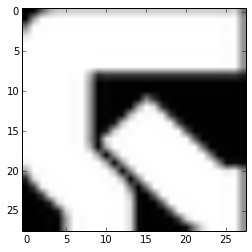

(1, 4096)


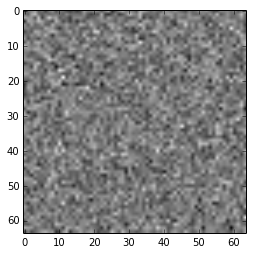

(1, 4096)


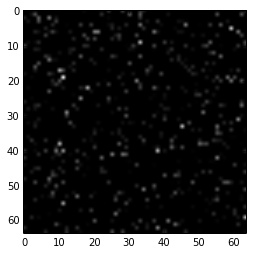


Label: 7
  imgIx:    1
  glbObsOOBYDf.iloc[imgIx]:
imgIx             1
labelY            7
labelYP           7
labelYPAcc     True
labelYPProb       1
Name: 1, dtype: object
  glbObsOOBX[imgIx, :][:5]:[ 0.5         0.48823529  0.5        -0.26862746 -0.5       ]
  img2DArr[:5, :5]:
[[ 0.5         0.48823529  0.5        -0.26862746 -0.5       ]
 [ 0.5         0.48823529  0.5        -0.26862746 -0.5       ]
 [ 0.5         0.48823529  0.5        -0.26862746 -0.5       ]
 [ 0.5         0.48823529  0.5        -0.26862746 -0.5       ]
 [ 0.5         0.48823529  0.5        -0.26862746 -0.5       ]]


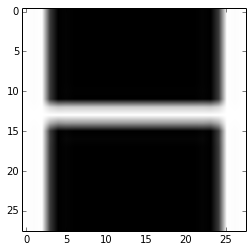

(1, 4096)


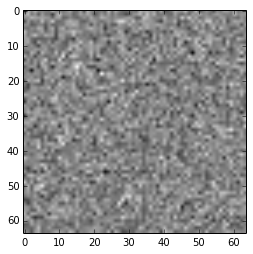

(1, 4096)


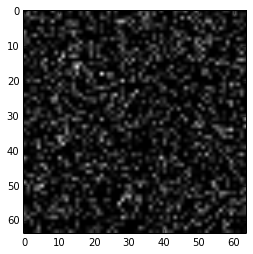

  imgIx: 4457
  glbObsOOBYDf.iloc[imgIx]:
imgIx           4457
labelY             8
labelYP            7
labelYPAcc     False
labelYPProb        1
Name: 4457, dtype: object
  glbObsOOBX[imgIx, :][:5]:[ 0.5         0.48431373  0.5        -0.04901961 -0.5       ]
  img2DArr[:5, :5]:
[[ 0.5         0.48431373  0.5        -0.04901961 -0.5       ]
 [ 0.5         0.48431373  0.5        -0.04901961 -0.5       ]
 [ 0.5         0.48431373  0.5        -0.04901961 -0.5       ]
 [ 0.5         0.48431373  0.5        -0.04901961 -0.5       ]
 [ 0.5         0.48431373  0.5        -0.04901961 -0.5       ]]


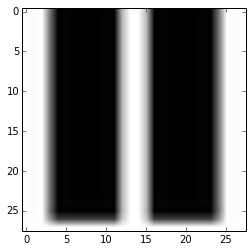

(1, 4096)


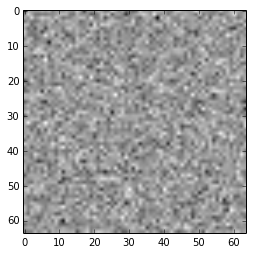

(1, 4096)


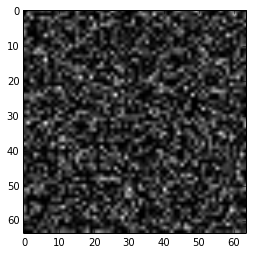


Label: 8
  imgIx: 5044
  glbObsOOBYDf.iloc[imgIx]:
imgIx          5044
labelY            8
labelYP           8
labelYPAcc     True
labelYPProb       1
Name: 5044, dtype: object
  glbObsOOBX[imgIx, :][:5]:[-0.25294119  0.01764706  0.28431374  0.47647059  0.49215686]
  img2DArr[:5, :5]:
[[-0.25294119  0.01764706  0.28431374  0.47647059  0.49215686]
 [-0.5        -0.5        -0.45294118 -0.32745099 -0.08431373]
 [-0.49215686 -0.49607843 -0.5        -0.5        -0.5       ]
 [-0.5        -0.5        -0.49607843 -0.49215686 -0.48823529]
 [-0.5        -0.5        -0.5        -0.5        -0.5       ]]


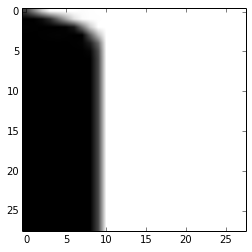

(1, 4096)


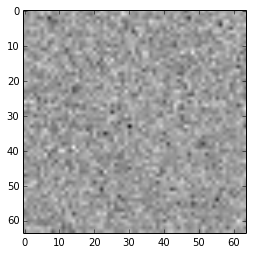

(1, 4096)


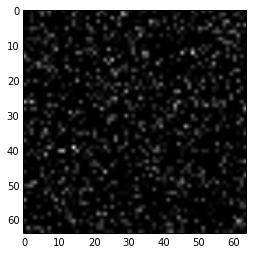

  imgIx: 1079
  glbObsOOBYDf.iloc[imgIx]:
imgIx              1079
labelY                3
labelYP               8
labelYPAcc        False
labelYPProb    0.999966
Name: 1079, dtype: object
  glbObsOOBX[imgIx, :][:5]:[-0.5 -0.5 -0.5 -0.5 -0.5]
  img2DArr[:5, :5]:
[[-0.5        -0.5        -0.5        -0.5        -0.5       ]
 [-0.48431373 -0.48431373 -0.48431373 -0.48431373 -0.48431373]
 [-0.5        -0.5        -0.5        -0.5        -0.5       ]
 [-0.10392157  0.00196078 -0.00196078  0.00196078  0.00196078]
 [ 0.5         0.5         0.5         0.5         0.5       ]]


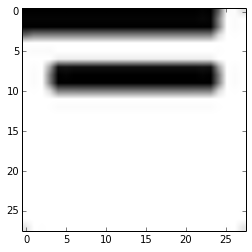

(1, 4096)


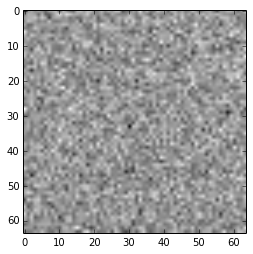

(1, 4096)


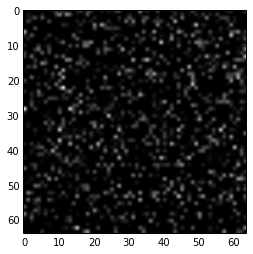


Label: 9
  imgIx:  816
  glbObsOOBYDf.iloc[imgIx]:
imgIx           816
labelY            9
labelYP           9
labelYPAcc     True
labelYPProb       1
Name: 816, dtype: object
  glbObsOOBX[imgIx, :][:5]:[-0.5 -0.5 -0.5 -0.5 -0.5]
  img2DArr[:5, :5]:
[[-0.5 -0.5 -0.5 -0.5 -0.5]
 [-0.5 -0.5 -0.5 -0.5 -0.5]
 [-0.5 -0.5 -0.5 -0.5 -0.5]
 [-0.5 -0.5 -0.5 -0.5 -0.5]
 [-0.5 -0.5 -0.5 -0.5 -0.5]]


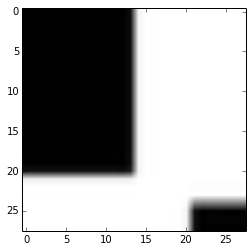

(1, 4096)


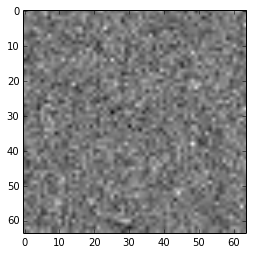

(1, 4096)


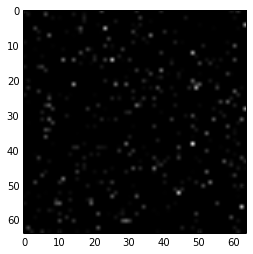

  imgIx: 4247
  glbObsOOBYDf.iloc[imgIx]:
imgIx              4247
labelY                3
labelYP               9
labelYPAcc        False
labelYPProb    0.999991
Name: 4247, dtype: object
  glbObsOOBX[imgIx, :][:5]:[-0.5 -0.5 -0.5 -0.5 -0.5]
  img2DArr[:5, :5]:
[[-0.5 -0.5 -0.5 -0.5 -0.5]
 [-0.5 -0.5 -0.5 -0.5 -0.5]
 [-0.5 -0.5 -0.5 -0.5 -0.5]
 [-0.5 -0.5 -0.5 -0.5 -0.5]
 [-0.5 -0.5 -0.5 -0.5 -0.5]]


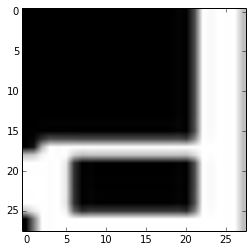

(1, 4096)


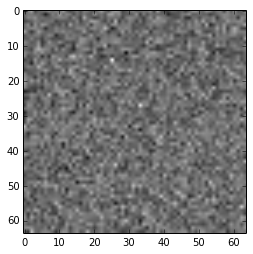

(1, 4096)


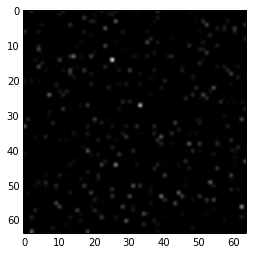

In [228]:
for label in xrange(num_labels):
#for label in xrange(1):    
    print("\nLabel:%2d" % (label))
#     imgIx = glbObsOOBYDf[(glbObsOOBYDf['labelYPAcc'] == True ) &
#                          (glbObsOOBYDf['labelYP'] == label)]['labelYPProb'].argmax()
    for imgIx in [glbObsOOBYDf[(glbObsOOBYDf['labelYPAcc'] == True ) &
                               (glbObsOOBYDf['labelYP'] == label)]['labelYPProb'].argmax(),
                  glbObsOOBYDf[(glbObsOOBYDf['labelYPAcc'] == False) &
                               (glbObsOOBYDf['labelYP'] == label)]['labelYPProb'].argmax()]:
        print("  imgIx:%5d" % (imgIx))
        print("  glbObsOOBYDf.iloc[imgIx]:" % ())
        print(glbObsOOBYDf.iloc[imgIx])
        print("  glbObsOOBX[imgIx, :][:5]:%s"% (glbObsOOBX[imgIx, :][:5]))
        img2DArr = glbObsOOBX[imgIx, :].reshape((glbObsOOBX[imgIx, :].shape[0] ** 0.5, \
                                                 glbObsOOBX[imgIx, :].shape[0] ** 0.5))
        print("  img2DArr[:5, :5]:"% ())
        print(img2DArr[:5, :5])
        plt.figure
        plt.imshow(img2DArr, cmap = plt.cm.gray)
        plt.show()

        print(glbObsOOBLyr1[imgIx, :].shape)
        img2DArr = glbObsOOBLyr1[imgIx, :].reshape((glbObsOOBLyr1[imgIx, :].shape[1] ** 0.5, \
                                                    glbObsOOBLyr1[imgIx, :].shape[1] ** 0.5))
        plt.figure
        plt.imshow(img2DArr, cmap = plt.cm.gray)
        plt.show()

        print(glbObsOOBLyr2[imgIx, :].shape)
        img2DArr = glbObsOOBLyr2[imgIx, :].reshape((glbObsOOBLyr2[imgIx, :].shape[1] ** 0.5, \
                                                    glbObsOOBLyr2[imgIx, :].shape[1] ** 0.5))
        plt.figure
        plt.imshow(img2DArr, cmap = plt.cm.gray)
        plt.show()

In [162]:
#print(glbMdlDf.l2Penalty1)
#print(glbMdlDf.isin({'l2Penalty1': [0], 'nRELUs': [0], 'l2Penalty3': [0]}))
# msk = glbMdlDf.isin({'l2Penalty1': [0], 'nRELUs': [0], 'l2Penalty3': [0]}).any()
# print(msk)
# print(type(msk))
#print(glbMdlDf[msk])
#print(glbMdlDf.isin({'l2Penalty1': [0], 'nRELUs': [0], 'l2Penalty3': [0]}).any())
#print(glbMdlDf.l2Penalty1.item() in [0])

print((glbMdlDf.l2Penalty1 == 0) &
      (glbMdlDf.nRELUs     == 0)
     ) 
print(glbMdlDf[glbMdlDf.l2Penalty1 == 0])
#tstMdlDf = glbMdlDf[glbmdlDf.l2Penalty1 == 0]

l2Penalty1
1.0000    False
0.1000    False
0.0000     True
0.0100    False
0.0001    False
0.0050    False
0.0030    False
0.0007    False
0.0005    False
0.0009    False
0.0010    False
dtype: bool
            l2Penalty1  nRELUs  \
l2Penalty1                       
0                    0       0   

                                                      tfGraph  \
l2Penalty1                                                      
0           <tensorflow.python.framework.ops.Graph object ...   

                                                       tfWgt1  \
l2Penalty1                                                      
0           [[-0.0834578275680542, -0.2806337773799896, 0....   

                                                       tfBss1  tfSsnLoss  \
l2Penalty1                                                                 
0           [0.33371445536613464, 0.1911279559135437, -1.8...   1.028475   

            OOBAccuracy  NewAccuracy  l2Penalty3  
l2Penalty1                

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [19]:
# store matrices as a string separated by semicolons & use np.matrix to convert from string
def fitMdl(l2Penalty1, nRELUs, l2Penalty3, num_steps = 3001):
    print(' ')
    print('fitMdl: l2Penalty1:%0.4e; nRELUs:%d; l2Penalty3:%0.4e; num_steps:%4d' % 
          (l2Penalty1, nRELUs, l2Penalty3, num_steps))
    
    if (nRELUs == 0) and (l2Penalty3 > 0):
        l2Penalty3 = 0
        print('  nRELUs == 0 overrides l2Penalty3 > 0 spec')
    
    tf.set_random_seed(123)
    #l2Penalty3 = 0
    #nRELUs = 0
    #l2Penalty1 = 0
    batch_size = 128
    #num_steps = 3001

    mdlDf = pd.DataFrame(
        {'num_steps': [num_steps], 'l2Penalty1': [l2Penalty1], 'nRELUs': [nRELUs], \
         'l2Penalty3': [l2Penalty3]})
    mdlDf['tfGraph'] = tf.Graph()
    with mdlDf['tfGraph'][0].as_default():

      # Input data. For the training data, we use a placeholder that will be fed
      # at run time with a training minibatch.
      tfObsFitX = tf.placeholder(tf.float32,
                                        shape=(batch_size, image_size * image_size))
      tfObsFitY = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
      tfObsOOBX = tf.constant(glbObsOOBX)
      tfObsNewX = tf.constant(glbObsNewX)

      # Variables.
      if (nRELUs == 0):
          tfWgt1 = tf.Variable(
            tf.truncated_normal([image_size * image_size, num_labels]), name = 'tfWgt1')
          tfBss1 = tf.Variable(tf.zeros([num_labels]), name = 'tfBss1')
          tfWgt3 = 0
          tfBss3 = 0
      else:  
          tfWgt1 = tf.Variable(
            tf.truncated_normal([image_size * image_size, nRELUs]    ), name = 'tfWgt1')
          tfBss1 = tf.Variable(tf.zeros([nRELUs]    ), name = 'tfBss1')
          tfWgt3 = tf.Variable(
            tf.truncated_normal([nRELUs, num_labels]), name = 'tfWgt3')
          tfBss3 = tf.Variable(tf.zeros([num_labels]), name = 'tfBss3')
        
      print(tfWgt1.initialized_value())
      print(tfBss1.initialized_value())
      if (nRELUs > 0):  
          print(tfWgt3.initialized_value())
          print(tfBss3.initialized_value())

      # Training computation.
      tfLayer1 = tf.matmul(tfObsFitX, tfWgt1) + tfBss1
      if (nRELUs == 0):  
          tfLayer3 = tfLayer1
      else:  
          tfLayer2 = tf.nn.relu(tfLayer1)
          tfLayer3 = tf.matmul(tfLayer2, tfWgt3) + tfBss3
        
      if (nRELUs == 0):          
          tfLoss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(tfLayer3, tfObsFitY))        
      else:          
          tfLoss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(tfLayer3, tfObsFitY) + 
                                                    l2Penalty1 * tf.nn.l2_loss(tfWgt1) + 
                                                    l2Penalty3 * tf.nn.l2_loss(tfWgt3))

      # Optimizer.
      tfOptimizer = tf.train.GradientDescentOptimizer(0.5).minimize(tfLoss)

      # Predictions for the training, validation, and test data.
      tfObsFitYP = tf.nn.softmax(tfLayer3)
      if (nRELUs == 0):
          tfObsOOBYP = tf.nn.softmax(tf.matmul(tfObsOOBX, tfWgt1) + tfBss1)            
          tfObsNewYP = tf.nn.softmax(tf.matmul(tfObsNewX, tfWgt1) + tfBss1)
      else:      
          tfObsOOBYP = tf.nn.softmax(
            tf.matmul(tf.nn.relu(tf.matmul(tfObsOOBX, tfWgt1) + tfBss1), tfWgt3) + tfBss3)        
          tfObsNewYP = tf.nn.softmax(
            tf.matmul(tf.nn.relu(tf.matmul(tfObsNewX, tfWgt1) + tfBss1), tfWgt3) + tfBss3)        

    with tf.Session(graph = mdlDf['tfGraph'][0]) as session:
      tf.initialize_all_variables().run()
      print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (glbObsFitY.shape[0] - batch_size)
        # Generate a minibatch.
        obsBthX = glbObsFitX[offset:(offset + batch_size), :]
        obsBthY = glbObsFitY[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tfObsFitX : obsBthX, tfObsFitY : obsBthY}
        tfSsnOptimizer, tfSsnLoss, tfSsnObsFitYP = session.run(
          [tfOptimizer, tfLoss, tfObsFitYP], feed_dict = feed_dict)
        if (step % 500 == 0):
          print("obsFitBth loss at step %4d: %.4e" % (step, tfSsnLoss))
          print("obsFitBth accuracy: %0.4f" % accuracy(tfSsnObsFitYP,        obsBthY))
          print("obsOOB    accuracy: %0.4f" % accuracy(tfObsOOBYP.eval(), glbObsOOBY))

      print("Optimized")
      mdlDf.ix[0, 'tfWgt1'] = str(tfWgt1.eval().tolist())    
      print("  tfWgt1:")
      pprint.pprint(tfWgt1.eval())
      #print(type(tfBss1.eval()))
      mdlDf.ix[0, 'tfBss1'] = str(tfBss1.eval().tolist())
      print("  tfBss1:")
      pprint.pprint(tfBss1.eval())
        
      if (nRELUs > 0):  
          mdlDf.ix[0, 'tfWgt3'] = str(tfWgt3.eval().tolist())    
          print("  tfWgt3:")
          pprint.pprint(tfWgt3.eval())
          mdlDf.ix[0, 'tfBss3'] = str(tfBss3.eval().tolist())
          print("  tfBss3:")
          pprint.pprint(tfBss3.eval())
        
      mdlDf.ix[0, 'tfSsnLoss'] = tfSsnLoss  
      mdlDf.ix[0, 'OOBAccuracy'] = accuracy(tfObsOOBYP.eval(), glbObsOOBY)
      print(    "obsOOB    accuracy: %0.4f" % mdlDf.ix[0, 'OOBAccuracy'])
      mdlDf.ix[0, 'NewAccuracy'] = accuracy(tfObsNewYP.eval(), glbObsNewY)
      print(    "obsNew    accuracy: %0.4f" % mdlDf.ix[0, 'NewAccuracy'])

    return(mdlDf)

In [28]:
mdlDf = fitMdl(l2Penalty1 = glbMdlDf.ix[bstMdlIx, 'l2Penalty1'], 
               #nRELUs     = glbMdlDf.ix[bstMdlIx, 'nRELUs'], 
               nRELUs     = 1024,                
               l2Penalty3 = glbMdlDf.ix[bstMdlIx, 'l2Penalty3'], 
               num_steps = 2001)
print(mdlDf)

 
fitMdl: l2Penalty1:1.0000e-03; nRELUs:1024; l2Penalty3:1.0000e-03; num_steps:2001
Tensor("Identity:0", shape=TensorShape([Dimension(784), Dimension(1024)]), dtype=float32)
Tensor("Identity_1:0", shape=TensorShape([Dimension(1024)]), dtype=float32)
Tensor("Identity_2:0", shape=TensorShape([Dimension(1024), Dimension(10)]), dtype=float32)
Tensor("Identity_3:0", shape=TensorShape([Dimension(10)]), dtype=float32)
Initialized
obsFitBth loss at step    0: 7.6674e+02
obsFitBth accuracy: 0.1016
obsOOB    accuracy: 0.2634
obsFitBth loss at step  500: 2.1477e+02
obsFitBth accuracy: 0.7656
obsOOB    accuracy: 0.7936
obsFitBth loss at step 1000: 1.1402e+02
obsFitBth accuracy: 0.8281
obsOOB    accuracy: 0.8054
obsFitBth loss at step 1500: 6.9023e+01
obsFitBth accuracy: 0.8438
obsOOB    accuracy: 0.8292
obsFitBth loss at step 2000: 4.1485e+01
obsFitBth accuracy: 0.7969
obsOOB    accuracy: 0.8459
Optimized
  tfWgt1:
array([[-0.03078995,  0.36128932,  0.32783175, ...,  0.23777393,
         0.5119825

In [71]:
#num_stepsSearch  = [2001, 3001, 4001]
num_stepsSearch  = [4001]
l2Penalty1Search = [0, 1e-04, 1e-03, 1e-02]
#l2Penalty1Search = [bslMdlParams.l2Penalty1]
#nRELUsSearch     = [0] + [2 ** elm for elm in [0, 1, 8, 10]]
nRELUsSearch     = [bslMdlParams.nRELUs]
#l2Penalty3Search = [0, 1e-04, 1e-03, 1e-02]
l2Penalty3Search = [0, 1e-05, 1e-04, 1e-03]
#l2Penalty3Search = [bslMdlParams.l2Penalty3]
for num_steps in num_stepsSearch:
    for l2Penalty1 in l2Penalty1Search:
        for nRELUs in nRELUsSearch:
            for l2Penalty3 in l2Penalty3Search:
                if (nRELUs == 0):
                    l2Penalty3 = 0

                if (glbMdlDf.shape[0] == 0) or \
                   (glbMdlDf[
                            (glbMdlDf.num_steps  == num_steps ) & 
                            (glbMdlDf.l2Penalty1 == l2Penalty1) & 
                            (glbMdlDf.nRELUs     == nRELUs    ) &
                            (glbMdlDf.l2Penalty3 == l2Penalty3) 
                            ].shape[0] == 0):
    #                     print('fitMdl: l2Penalty1:%0.4e; nRELUs:%d; l2Penalty3:%0.4e' % 
    #                               (l2Penalty1, nRELUs, l2Penalty3))
                    mdlDf = fitMdl(l2Penalty1, nRELUs, l2Penalty3, num_steps)
                    glbMdlDf = glbMdlDf.append(mdlDf)

 
fitMdl: l2Penalty1:0.0000e+00; nRELUs:1024; l2Penalty3:1.0000e-05; num_steps:4001
Tensor("Identity:0", shape=TensorShape([Dimension(784), Dimension(1024)]), dtype=float32)
Tensor("Identity_1:0", shape=TensorShape([Dimension(1024)]), dtype=float32)
Tensor("Identity_2:0", shape=TensorShape([Dimension(1024), Dimension(10)]), dtype=float32)
Tensor("Identity_3:0", shape=TensorShape([Dimension(10)]), dtype=float32)
Initialized
obsFitBth loss at step    0: 3.4125e+02
obsFitBth accuracy: 0.0547
obsOOB    accuracy: 0.1510
obsFitBth loss at step  500: 4.0181e+01
obsFitBth accuracy: 0.7656
obsOOB    accuracy: 0.7861
obsFitBth loss at step 1000: 9.0614e+00
obsFitBth accuracy: 0.7656
obsOOB    accuracy: 0.8017
obsFitBth loss at step 1500: 1.7823e+01
obsFitBth accuracy: 0.7422
obsOOB    accuracy: 0.8009
obsFitBth loss at step 2000: 1.1730e+01
obsFitBth accuracy: 0.8125
obsOOB    accuracy: 0.8056
obsFitBth loss at step 2500: 4.3247e+00
obsFitBth accuracy: 0.7969
obsOOB    accuracy: 0.8007
obsFitBth

In [74]:
#print('OOBAccuracy' in glbMdlDf.columns)
print(glbMdlDf[(glbMdlDf.num_steps  == 4001) & 
               (glbMdlDf.l2Penalty3 == 1e-05 )
              ][['OOBAccuracy', 'tfSsnLoss']].sort(['OOBAccuracy']))

                                        OOBAccuracy  tfSsnLoss
num_steps l2Penalty1 nRELUs l2Penalty3                        
4001      0.0000     1024   0.00001          0.8244   1.366948
          0.0100     1024   0.00001          0.8252   0.572319
          0.0001     1024   0.00001          0.8281  20.880917
          0.0010     1024   0.00001          0.8718   5.816156


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [78]:
pltNumStepsFn = robjects.r("""
    require(ggplot2)
    require(tidyr)
    require(grid)
    
    multiplot <- function(..., plotlist=NULL, cols) {
        require(grid)

        # Make a list from the ... arguments and plotlist
        plots <- c(list(...), plotlist)

        numPlots = length(plots)

        # Make the panel
        plotCols = cols                          # Number of columns of plots
        plotRows = ceiling(numPlots/plotCols) # Number of rows needed, calculated from # of cols

        # Set up the page
        grid.newpage()
        pushViewport(viewport(layout = grid.layout(plotRows, plotCols)))
        vplayout <- function(x, y)
            viewport(layout.pos.row = x, layout.pos.col = y)

        # Make each plot, in the correct location
        for (i in 1:numPlots) {
            curRow = ceiling(i/plotCols)
            curCol = (i-1) %% plotCols + 1
            print(plots[[i]], vp = vplayout(curRow, curCol ))
        }

    }
    
    function(df) {
#         pltDf <- tidyr::gather(df, 'key', 'value', 
#                                 -num_steps, -l2Penalty1, -nRELUs, -l2Penalty3)
        bstDf <- tidyr::gather(df[which.max(df$OOBAccuracy), ], 'key', 'value', 
                                -num_steps, -l2Penalty1, -nRELUs, -l2Penalty3)
        pltLst <- list()
        print("num_steps: ")
        print(sort(unique(df$num_steps)))
        for (num_steps in sort(unique(df$num_steps))) {
#         for (num_steps in sort(unique(df$num_steps))[2:3]) {        
            pltDf <- tidyr::gather(df[df$num_steps == num_steps, ], 'key', 'value', 
                                    -num_steps, -l2Penalty1, -nRELUs, -l2Penalty3)        
            #tfSsnLoss OOBAccuracy
            gp <- ggplot(pltDf, aes_string(x = 'l2Penalty1', y = 'value', group = 'nRELUs')) + 
                #geom_line(aes_string(color = 'nRELUs')) + 
                geom_line(aes(color = as.factor(nRELUs))) +             
                geom_hline(data = subset(pltDf, (l2Penalty1 == 0)), 
                            aes(yintercept = value, color = as.factor(nRELUs)), 
                            linetype = 'dashed') + 
#                 geom_point(data = pltDf[(pltDf$key == 'OOBAccuracy') & 
#                                         (pltDf$value == max(df$OOBAccuracy)), ],
#                             shape = 5, color = 'black', size = 3) +             
                geom_point(data = bstDf[(bstDf$key == 'OOBAccuracy'), ],
                            shape = 5, color = 'black', size = 3) +             
                scale_x_log10() + ylab('') +
                scale_linetype_identity(guide = "legend") + 
                #guides(linetype = "legend") + 
                facet_grid('key ~ l2Penalty3', labeller = label_both, scales = 'free_y') + 
                theme(legend.position = "bottom") +
                ggtitle(sprintf('Logistic with RELUs SGD: num_steps: %4d', num_steps))
            pltLst[[as.character(num_steps)]] <- gp    
        }        
         
        #ggsave('3_regularization_logisticSGD.png', plot = gp, width = 6.5, height = 5.5)
        png(filename = '3_regularization_logisticSGD.png', 
#            width = 6.5, height = 5.5, units = "in")
            width = 480 * 3, height = 480 * 3)
        multiplot(plotlist = pltLst, cols = 1)
        dev.off()
    }
""")

pltNumStepsFn(glbMdlRDf2)

[1] "num_steps: "
[1] 2001 3001 4001


<IntVector - Python:0x20055fcf8 / R:0x7fd5f7009518>
[       1]

In [28]:
#print(glbMdlDf['num_steps'].value_counts())

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [80]:
#glbMdlDf['kpRELUs'] = 1.0

In [86]:
# store matrices as a string separated by semicolons & use np.matrix to convert from string
def fitMdlDropout(num_steps, l2Penalty1, nRELUs, kpRELUs, l2Penalty3):
    print(' ')
    print('fitMdlDroput: ' + 
          'num_steps:%4d; l2Penalty1:%0.4e; nRELUs:%d; kpRELUs:%0.4f; l2Penalty3:%0.4e;' % 
          (num_steps, l2Penalty1, nRELUs, kpRELUs, l2Penalty3))
    
    if (nRELUs == 0) and (kpRELUs < 1.0):
        kpRELUs = 1.0
        print('  nRELUs == 0 overrides kpRELUs < 1.0 spec')
    
    if (nRELUs == 0) and (l2Penalty3 > 0):
        l2Penalty3 = 0
        print('  nRELUs == 0 overrides l2Penalty3 > 0 spec')
    
    tf.set_random_seed(123)
    batch_size = 128

    mdlDf = pd.DataFrame(
        {'num_steps': [num_steps], 'l2Penalty1': [l2Penalty1], \
         'nRELUs': [nRELUs], 'kpRELUs': [kpRELUs], \
         'l2Penalty3': [l2Penalty3]})
    mdlDf['tfGraph'] = tf.Graph()
    with mdlDf['tfGraph'][0].as_default():

      # Input data. For the training data, we use a placeholder that will be fed
      # at run time with a training minibatch.
      tfObsFitX = tf.placeholder(tf.float32,
                                        shape=(batch_size, image_size * image_size))
      tfObsFitY = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
      tfObsOOBX = tf.constant(glbObsOOBX)
      tfObsNewX = tf.constant(glbObsNewX)

      # Variables.
      if (nRELUs == 0):
          tfWgt1 = tf.Variable(
            tf.truncated_normal([image_size * image_size, num_labels]), name = 'tfWgt1')
          tfBss1 = tf.Variable(tf.zeros([num_labels]), name = 'tfBss1')
          tfWgt3 = 0
          tfBss3 = 0
      else:  
          tfWgt1 = tf.Variable(
            tf.truncated_normal([image_size * image_size, nRELUs]    ), name = 'tfWgt1')
          tfBss1 = tf.Variable(tf.zeros([nRELUs]    ), name = 'tfBss1')
          tfWgt3 = tf.Variable(
            tf.truncated_normal([nRELUs, num_labels]), name = 'tfWgt3')
          tfBss3 = tf.Variable(tf.zeros([num_labels]), name = 'tfBss3')
        
      print(tfWgt1.initialized_value())
      print(tfBss1.initialized_value())
      if (nRELUs > 0):  
          print(tfWgt3.initialized_value())
          print(tfBss3.initialized_value())

      # Training computation.
      tfLayer1 = tf.matmul(tfObsFitX, tfWgt1) + tfBss1
      if (nRELUs == 0):  
          tfLayer3 = tfLayer1
      else:  
          tfLayer2 = tf.nn.relu(tfLayer1)
          tfLayer2 = tf.nn.dropout(tfLayer2, kpRELUs)  
          tfLayer3 = tf.matmul(tfLayer2, tfWgt3) + tfBss3
        
      if (nRELUs == 0):          
          tfLoss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(tfLayer3, tfObsFitY))        
      else:          
          tfLoss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(tfLayer3, tfObsFitY) + 
                                                    l2Penalty1 * tf.nn.l2_loss(tfWgt1) + 
                                                    l2Penalty3 * tf.nn.l2_loss(tfWgt3))

      # Optimizer.
      tfOptimizer = tf.train.GradientDescentOptimizer(0.5).minimize(tfLoss)

      # Predictions for the training, validation, and test data.
      tfObsFitYP = tf.nn.softmax(tfLayer3)
      if (nRELUs == 0):
          tfObsOOBYP = tf.nn.softmax(tf.matmul(tfObsOOBX, tfWgt1) + tfBss1)            
          tfObsNewYP = tf.nn.softmax(tf.matmul(tfObsNewX, tfWgt1) + tfBss1)
      else:      
          tfObsOOBYP = tf.nn.softmax(
            tf.matmul(tf.nn.relu(tf.matmul(tfObsOOBX, tfWgt1) + tfBss1), tfWgt3) + tfBss3)        
          tfObsNewYP = tf.nn.softmax(
            tf.matmul(tf.nn.relu(tf.matmul(tfObsNewX, tfWgt1) + tfBss1), tfWgt3) + tfBss3)        

    with tf.Session(graph = mdlDf['tfGraph'][0]) as session:
      tf.initialize_all_variables().run()
      print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (glbObsFitY.shape[0] - batch_size)
        # Generate a minibatch.
        obsBthX = glbObsFitX[offset:(offset + batch_size), :]
        obsBthY = glbObsFitY[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tfObsFitX : obsBthX, tfObsFitY : obsBthY}
        tfSsnOptimizer, tfSsnLoss, tfSsnObsFitYP = session.run(
          [tfOptimizer, tfLoss, tfObsFitYP], feed_dict = feed_dict)
        if (step % 500 == 0):
          print("obsFitBth loss at step %4d: %.4e" % (step, tfSsnLoss))
          print("obsFitBth accuracy: %0.4f" % accuracy(tfSsnObsFitYP,        obsBthY))
          print("obsOOB    accuracy: %0.4f" % accuracy(tfObsOOBYP.eval(), glbObsOOBY))

      print("Optimized")
      mdlDf.ix[0, 'tfWgt1'] = str(tfWgt1.eval().tolist())    
      print("  tfWgt1:")
      pprint.pprint(tfWgt1.eval())
      #print(type(tfBss1.eval()))
      mdlDf.ix[0, 'tfBss1'] = str(tfBss1.eval().tolist())
      print("  tfBss1:")
      pprint.pprint(tfBss1.eval())
        
      if (nRELUs > 0):  
          mdlDf.ix[0, 'tfWgt3'] = str(tfWgt3.eval().tolist())    
          print("  tfWgt3:")
          pprint.pprint(tfWgt3.eval())
          mdlDf.ix[0, 'tfBss3'] = str(tfBss3.eval().tolist())
          print("  tfBss3:")
          pprint.pprint(tfBss3.eval())
        
      mdlDf.ix[0, 'tfSsnLoss'] = tfSsnLoss  
      mdlDf.ix[0, 'OOBAccuracy'] = accuracy(tfObsOOBYP.eval(), glbObsOOBY)
      print(    "obsOOB    accuracy: %0.4f" % mdlDf.ix[0, 'OOBAccuracy'])
      mdlDf.ix[0, 'NewAccuracy'] = accuracy(tfObsNewYP.eval(), glbObsNewY)
      print(    "obsNew    accuracy: %0.4f" % mdlDf.ix[0, 'NewAccuracy'])

    return(mdlDf)

In [87]:
mdlDf = fitMdlDropout(
            num_steps  = glbMdlDf.ix[bslMdlIx, 'num_steps' ],
            l2Penalty1 = glbMdlDf.ix[bslMdlIx, 'l2Penalty1'], 
            nRELUs     = glbMdlDf.ix[bslMdlIx, 'nRELUs'    ],
            #kpRELUs    = glbMdlDf.ix[bslMdlIx, 'kpRELUs'   ],    
            kpRELUs    = 0.5,        
            l2Penalty3 = glbMdlDf.ix[bslMdlIx, 'l2Penalty3']
               )
print(mdlDf)

 
fitMdlDroput: num_steps:4001; l2Penalty1:1.0000e-03; nRELUs:1024; kpRELUs:0.5000; l2Penalty3:1.0000e-04;
Tensor("Identity:0", shape=TensorShape([Dimension(784), Dimension(1024)]), dtype=float32)
Tensor("Identity_1:0", shape=TensorShape([Dimension(1024)]), dtype=float32)
Tensor("Identity_2:0", shape=TensorShape([Dimension(1024), Dimension(10)]), dtype=float32)
Tensor("Identity_3:0", shape=TensorShape([Dimension(10)]), dtype=float32)
Initialized
obsFitBth loss at step    0: 7.7351e+02
obsFitBth accuracy: 0.1094
obsOOB    accuracy: 0.3515
obsFitBth loss at step  500: 2.3047e+02
obsFitBth accuracy: 0.7422
obsOOB    accuracy: 0.7817
obsFitBth loss at step 1000: 1.2056e+02
obsFitBth accuracy: 0.7578
obsOOB    accuracy: 0.7875
obsFitBth loss at step 1500: 7.2548e+01
obsFitBth accuracy: 0.7188
obsOOB    accuracy: 0.8123
obsFitBth loss at step 2000: 4.2456e+01
obsFitBth accuracy: 0.7500
obsOOB    accuracy: 0.8260
obsFitBth loss at step 2500: 2.5514e+01
obsFitBth accuracy: 0.8281
obsOOB    acc

In [92]:
#num_stepsSearch  = [2001, 3001, 4001]
num_stepsSearch  = [4001]
#l2Penalty1Search = [0, 1e-04, 1e-03, 1e-02]
l2Penalty1Search = [bslMdlParams.l2Penalty1]
#nRELUsSearch     = [0] + [2 ** elm for elm in [0, 1, 8, 10]]
nRELUsSearch     = [bslMdlParams.nRELUs]
kpRELUsSearch     = [0.6, 0.8, 1.0]
#l2Penalty3Search = [0, 1e-05, 1e-04, 1e-03]
l2Penalty3Search = [bslMdlParams.l2Penalty3]
for num_steps in num_stepsSearch:
    for l2Penalty1 in l2Penalty1Search:
        for nRELUs in nRELUsSearch:
            for kpRELUs in kpRELUsSearch:            
                for l2Penalty3 in l2Penalty3Search:
                    if (nRELUs == 0):
                        kpRELUs = 1.0
                        l2Penalty3 = 0

                    if (glbMdlDf.shape[0] == 0) or \
                       (glbMdlDf[
                                (glbMdlDf.num_steps  == num_steps ) & 
                                (glbMdlDf.l2Penalty1 == l2Penalty1) & 
                                (glbMdlDf.nRELUs     == nRELUs    ) &
                                (glbMdlDf.kpRELUs    == kpRELUs   ) &                                
                                (glbMdlDf.l2Penalty3 == l2Penalty3) 
                                ].shape[0] == 0):
        #                     print('fitMdl: l2Penalty1:%0.4e; nRELUs:%d; l2Penalty3:%0.4e' % 
        #                               (l2Penalty1, nRELUs, l2Penalty3))
                        mdlDf = fitMdlDropout(num_steps, l2Penalty1, nRELUs, kpRELUs, l2Penalty3)
                        glbMdlDf = glbMdlDf.append(mdlDf)

 
fitMdlDroput: num_steps:4001; l2Penalty1:1.0000e-03; nRELUs:1024; kpRELUs:0.6000; l2Penalty3:1.0000e-04;
Tensor("Identity:0", shape=TensorShape([Dimension(784), Dimension(1024)]), dtype=float32)
Tensor("Identity_1:0", shape=TensorShape([Dimension(1024)]), dtype=float32)
Tensor("Identity_2:0", shape=TensorShape([Dimension(1024), Dimension(10)]), dtype=float32)
Tensor("Identity_3:0", shape=TensorShape([Dimension(10)]), dtype=float32)
Initialized
obsFitBth loss at step    0: 7.2452e+02
obsFitBth accuracy: 0.1172
obsOOB    accuracy: 0.3230
obsFitBth loss at step  500: 2.2395e+02
obsFitBth accuracy: 0.7578
obsOOB    accuracy: 0.7933
obsFitBth loss at step 1000: 1.1680e+02
obsFitBth accuracy: 0.7344
obsOOB    accuracy: 0.8003
obsFitBth loss at step 1500: 7.2088e+01
obsFitBth accuracy: 0.7578
obsOOB    accuracy: 0.8179
obsFitBth loss at step 2000: 4.2540e+01
obsFitBth accuracy: 0.7812
obsOOB    accuracy: 0.8295
obsFitBth loss at step 2500: 2.5405e+01
obsFitBth accuracy: 0.8359
obsOOB    acc

In [108]:
print(glbMdlDf[glbMdlDf.num_steps == 4001][['OOBAccuracy']])

                                                OOBAccuracy
num_steps l2Penalty1 nRELUs kpRELUs l2Penalty3             
4001      0.0000     1024   1.0     0.00000          0.8166
          0.0001     1024   1.0     0.00100          0.8186
                                    0.00010          0.8188
          0.0000     1024   1.0     0.00100          0.8203
                                    0.00010          0.8210
          0.0100     1024   1.0     0.00000          0.8242
          0.0000     1024   1.0     0.00001          0.8244
          0.0100     1024   1.0     0.00001          0.8252
          0.0001     1024   1.0     0.00001          0.8281
                                    0.00000          0.8285
          0.0100     1024   1.0     0.00010          0.8369
                                    0.00100          0.8440
          0.0010     1024   1.0     0.01000          0.8562
                            0.6     0.00010          0.8694
                            0.8     0.00

In [106]:
pltKpRELUsFn = robjects.r("""
    require(ggplot2)
    require(tidyr)
    require(grid)
    
    multiplot <- function(..., plotlist=NULL, cols) {
        require(grid)

        # Make a list from the ... arguments and plotlist
        plots <- c(list(...), plotlist)

        numPlots = length(plots)

        # Make the panel
        plotCols = cols                          # Number of columns of plots
        plotRows = ceiling(numPlots/plotCols) # Number of rows needed, calculated from # of cols

        # Set up the page
        grid.newpage()
        pushViewport(viewport(layout = grid.layout(plotRows, plotCols)))
        vplayout <- function(x, y)
            viewport(layout.pos.row = x, layout.pos.col = y)

        # Make each plot, in the correct location
        for (i in 1:numPlots) {
            curRow = ceiling(i/plotCols)
            curCol = (i-1) %% plotCols + 1
            print(plots[[i]], vp = vplayout(curRow, curCol ))
        }

    }
    
    function(df) {
        bstDf <- tidyr::gather(df[which.max(df$OOBAccuracy), ], 'key', 'value', 
                                -num_steps, -l2Penalty1, -nRELUs, -kpRELUs, -l2Penalty3)
        pltLst <- list()
        print("num_steps: ")
        print(sort(unique(df$num_steps)))
        print("kpRELUs: ")
        print(sort(unique(df$kpRELUs)))
        for (num_steps in sort(unique(df$num_steps))) 
            for (kpRELUs in sort(unique(df$kpRELUs))) {        
                pltDf <- tidyr::gather(df[(df$num_steps == num_steps) & 
                                          (df$kpRELUs   == kpRELUs  )
                                            , ], 'key', 'value', 
                                        -num_steps, -l2Penalty1, -nRELUs, -kpRELUs, -l2Penalty3)        
                #tfSsnLoss OOBAccuracy
                gp <- ggplot(pltDf, aes_string(x = 'l2Penalty1', y = 'value', group = 'nRELUs')) + 
                    geom_line(aes(color = as.factor(nRELUs))) +             
                    geom_hline(data = subset(pltDf, (l2Penalty1 == 0)), 
                                aes(yintercept = value, color = as.factor(nRELUs)), 
                                linetype = 'dashed') + 
                    geom_point(data = bstDf[(bstDf$key == 'OOBAccuracy'), ],
                                shape = 5, color = 'black', size = 3) +             
                    scale_x_log10() + ylab('') +
                    scale_linetype_identity(guide = "legend") + 
                    #guides(linetype = "legend") + 
                    facet_grid('key ~ l2Penalty3', labeller = label_both, scales = 'free_y') + 
                    theme(legend.position = "bottom") +
                    ggtitle(sprintf('Logistic with RELUs SGD: num_steps: %4d; kpRELUs: %0.4f', 
                            num_steps, kpRELUs))
                pltLst[[paste(as.character(num_steps), as.character(kpRELUs), 
                        sep = '#')]] <- gp    
        }        
         
        png(filename = '3_regularization_logisticSGD.png', 
            width = 480 * 3, height = 480 * 9)
        multiplot(plotlist = pltLst, cols = 1)
        dev.off()
    }
""")

pltKpRELUsFn(glbMdlRDf2)

[1] "num_steps: "
[1] 2001 3001 4001
[1] "kpRELUs: "
[1] 0.6 0.8 1.0


<IntVector - Python:0x20a2691b8 / R:0x7fd5e6a90458>
[       1]

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [19]:
#glbMdlDf['learnDecayRate'] = 1.00

In [8]:
# store matrices as a string separated by semicolons & use np.matrix to convert from string
def fitMdlLearnDecayRate(num_steps, learnDecayRate, l2Penalty1, nRELUs, kpRELUs, l2Penalty3):
    print('\nfitMdlLearnDecayRate: num_steps:%4d; learnDecayRate:%0.4f; ' % ( \
            num_steps, learnDecayRate))
    print('  l2Penalty1:%0.4e; nRELUs:%d; kpRELUs:%0.4f; l2Penalty3:%0.4e; ' % ( \
            l2Penalty1, nRELUs, kpRELUs, l2Penalty3))
#     print('fitMdlDroput: ' + 
#             'num_steps:%4d; learnDecayRate:%0.4f; ' + 
#             'l2Penalty1:%0.4e; nRELUs:%d; kpRELUs:%0.4f; l2Penalty3:%0.4e;' % 
#           (num_steps, learnDecayRate, l2Penalty1, nRELUs, kpRELUs, l2Penalty3))
    
    if (nRELUs == 0) and (kpRELUs < 1.0):
        kpRELUs = 1.0
        print('  nRELUs == 0 overrides kpRELUs < 1.0 spec')
    
    if (nRELUs == 0) and (l2Penalty3 > 0):
        l2Penalty3 = 0
        print('  nRELUs == 0 overrides l2Penalty3 > 0 spec')
    
    tf.set_random_seed(123)
    batch_size = 128

    mdlDf = pd.DataFrame(
        {'num_steps': [num_steps], 'learnDecayRate': [learnDecayRate], \
         'l2Penalty1': [l2Penalty1], \
         'nRELUs': [nRELUs], 'kpRELUs': [kpRELUs], \
         'l2Penalty3': [l2Penalty3]})
    mdlDf['tfGraph'] = tf.Graph()
    with mdlDf['tfGraph'][0].as_default():

      # Input data. For the training data, we use a placeholder that will be fed
      # at run time with a training minibatch.
      tfObsFitX = tf.placeholder(tf.float32,
                                        shape=(batch_size, image_size * image_size))
      tfObsFitY = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
      tfObsOOBX = tf.constant(glbObsOOBX)
      tfObsNewX = tf.constant(glbObsNewX)

      # Variables.
      if (nRELUs == 0):
          tfWgt1 = tf.Variable(
            tf.truncated_normal([image_size * image_size, num_labels]), name = 'tfWgt1')
          tfBss1 = tf.Variable(tf.zeros([num_labels]), name = 'tfBss1')
          tfWgt3 = 0
          tfBss3 = 0
      else:  
          tfWgt1 = tf.Variable(
            tf.truncated_normal([image_size * image_size, nRELUs]    ), name = 'tfWgt1')
          tfBss1 = tf.Variable(tf.zeros([nRELUs]    ), name = 'tfBss1')
          tfWgt3 = tf.Variable(
            tf.truncated_normal([nRELUs, num_labels]), name = 'tfWgt3')
          tfBss3 = tf.Variable(tf.zeros([num_labels]), name = 'tfBss3')
        
      print(tfWgt1.initialized_value())
      print(tfBss1.initialized_value())
      if (nRELUs > 0):  
          print(tfWgt3.initialized_value())
          print(tfBss3.initialized_value())

      # Training computation.
      tfLayer1 = tf.matmul(tfObsFitX, tfWgt1) + tfBss1
      if (nRELUs == 0):  
          tfLayer3 = tfLayer1
      else:  
          tfLayer2 = tf.nn.relu(tfLayer1)
          tfLayer2 = tf.nn.dropout(tfLayer2, kpRELUs)  
          tfLayer3 = tf.matmul(tfLayer2, tfWgt3) + tfBss3
        
      if (nRELUs == 0):          
          tfLoss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(tfLayer3, tfObsFitY))        
      else:          
          tfLoss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(tfLayer3, tfObsFitY) + 
                                                    l2Penalty1 * tf.nn.l2_loss(tfWgt1) + 
                                                    l2Penalty3 * tf.nn.l2_loss(tfWgt3))

      # Optimizer.
      tfGlbStep = tf.Variable(0, trainable = False)
      tfInitLearnRate = 0.5
      tfLearnRate = tf.train.exponential_decay(tfInitLearnRate, tfGlbStep, 1000, learnDecayRate,
                                              staircase = True)
      tfOptimizer = tf.train.GradientDescentOptimizer(tfLearnRate).minimize(tfLoss, 
                                                                        global_step = tfGlbStep)

      # Predictions for the training, validation, and test data.
      tfObsFitYP = tf.nn.softmax(tfLayer3)
      if (nRELUs == 0):
          tfObsOOBYP = tf.nn.softmax(tf.matmul(tfObsOOBX, tfWgt1) + tfBss1)            
          tfObsNewYP = tf.nn.softmax(tf.matmul(tfObsNewX, tfWgt1) + tfBss1)
      else:      
          tfObsOOBYP = tf.nn.softmax(
            tf.matmul(tf.nn.relu(tf.matmul(tfObsOOBX, tfWgt1) + tfBss1), tfWgt3) + tfBss3)        
          tfObsNewYP = tf.nn.softmax(
            tf.matmul(tf.nn.relu(tf.matmul(tfObsNewX, tfWgt1) + tfBss1), tfWgt3) + tfBss3)        

    with tf.Session(graph = mdlDf['tfGraph'][0]) as session:
      tf.initialize_all_variables().run()
      print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (glbObsFitY.shape[0] - batch_size)
        # Generate a minibatch.
        obsBthX = glbObsFitX[offset:(offset + batch_size), :]
        obsBthY = glbObsFitY[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tfObsFitX : obsBthX, tfObsFitY : obsBthY}
        tfSsnOptimizer, tfSsnLoss, tfSsnObsFitYP = session.run(
          [tfOptimizer, tfLoss, tfObsFitYP], feed_dict = feed_dict)
        if (step % 500 == 0):
          print("obsFitBth loss at step %4d: %.4e" % (step, tfSsnLoss))
          print("obsFitBth accuracy: %0.4f" % accuracy(tfSsnObsFitYP,        obsBthY))
          print("obsOOB    accuracy: %0.4f" % accuracy(tfObsOOBYP.eval(), glbObsOOBY))

      print("Optimized")
      mdlDf.ix[0, 'tfWgt1'] = str(tfWgt1.eval().tolist())    
      print("  tfWgt1:")
      pprint.pprint(tfWgt1.eval())
      #print(type(tfBss1.eval()))
      mdlDf.ix[0, 'tfBss1'] = str(tfBss1.eval().tolist())
      print("  tfBss1:")
      pprint.pprint(tfBss1.eval())
        
      if (nRELUs > 0):  
          mdlDf.ix[0, 'tfWgt3'] = str(tfWgt3.eval().tolist())    
          print("  tfWgt3:")
          pprint.pprint(tfWgt3.eval())
          mdlDf.ix[0, 'tfBss3'] = str(tfBss3.eval().tolist())
          print("  tfBss3:")
          pprint.pprint(tfBss3.eval())
        
      mdlDf.ix[0, 'tfSsnLoss'] = tfSsnLoss  
      mdlDf.ix[0, 'OOBAccuracy'] = accuracy(tfObsOOBYP.eval(), glbObsOOBY)
      print(    "obsOOB    accuracy: %0.4f" % mdlDf.ix[0, 'OOBAccuracy'])
      mdlDf.ix[0, 'NewAccuracy'] = accuracy(tfObsNewYP.eval(), glbObsNewY)
      print(    "obsNew    accuracy: %0.4f" % mdlDf.ix[0, 'NewAccuracy'])

    return(mdlDf)

In [36]:
#print(glbMdlDf.ix[bslMdlIx, 'l2Penalty3'])
mdlDf = fitMdlLearnDecayRate(
            num_steps      = glbMdlDf.ix[bslMdlIx, 'num_steps' ],
            learnDecayRate = 0.95,    
            l2Penalty1     = glbMdlDf.ix[bslMdlIx, 'l2Penalty1'], 
            nRELUs         = glbMdlDf.ix[bslMdlIx, 'nRELUs'    ],
            kpRELUs        = glbMdlDf.ix[bslMdlIx, 'kpRELUs'   ],    
            l2Penalty3     = glbMdlDf.ix[bslMdlIx, 'l2Penalty3']
               )
print(mdlDf)


fitMdlLearnDecayRate: num_steps:4001; learnDecayRate:0.9500; 
  l2Penalty1:1.0000e-03; nRELUs:1024; kpRELUs:1.0000; l2Penalty3:1.0000e-04; 
Tensor("Identity:0", shape=TensorShape([Dimension(784), Dimension(1024)]), dtype=float32)
Tensor("Identity_1:0", shape=TensorShape([Dimension(1024)]), dtype=float32)
Tensor("Identity_2:0", shape=TensorShape([Dimension(1024), Dimension(10)]), dtype=float32)
Tensor("Identity_3:0", shape=TensorShape([Dimension(10)]), dtype=float32)
Initialized
obsFitBth loss at step    0: 6.2860e+02
obsFitBth accuracy: 0.0781
obsOOB    accuracy: 0.2154
obsFitBth loss at step  500: 2.1563e+02
obsFitBth accuracy: 0.7812
obsOOB    accuracy: 0.7958
obsFitBth loss at step 1000: 1.1529e+02
obsFitBth accuracy: 0.8125
obsOOB    accuracy: 0.8024
obsFitBth loss at step 1500: 7.2412e+01
obsFitBth accuracy: 0.7734
obsOOB    accuracy: 0.8268
obsFitBth loss at step 2000: 4.3661e+01
obsFitBth accuracy: 0.8047
obsOOB    accuracy: 0.8397
obsFitBth loss at step 2500: 2.7738e+01
obsFit

In [36]:
#num_stepsSearch  = [2001, 3001, 4001]
num_stepsSearch  = [bslMdlParams.num_steps]
#learnDecayRateSearch  = [0.85, 0.90, 0.95]
learnDecayRateSearch = [bslMdlParams.learnDecayRate]
l2Penalty1Search = [0, 1e-04, 1e-03, 1e-02]
#l2Penalty1Search = [bslMdlParams.l2Penalty1]
#nRELUsSearch     = [0] + [2 ** elm for elm in [0, 1, 8, 10]]
nRELUsSearch     = [bslMdlParams.nRELUs]
#kpRELUsSearch     = [0.6, 0.8, 1.0]
kpRELUsSearch     = [0.9]
#kpRELUsSearch     = [bslMdlParams.kpRELUs]
#l2Penalty3Search = [0, 1e-05, 1e-04, 1e-03]
l2Penalty3Search = [1e-05, 1e-04, 1e-03]
#l2Penalty3Search = [bslMdlParams.l2Penalty3]
for num_steps in num_stepsSearch:
    for learnDecayRate in learnDecayRateSearch:
        for l2Penalty1 in l2Penalty1Search:
            for nRELUs in nRELUsSearch:
                for kpRELUs in kpRELUsSearch:            
                    for l2Penalty3 in l2Penalty3Search:
                        if (nRELUs == 0):
                            kpRELUs = 1.0
                            l2Penalty3 = 0

                        if (glbMdlDf.shape[0] == 0) or \
                           (glbMdlDf[
                                    (glbMdlDf.num_steps       == num_steps ) & 
                                    (glbMdlDf.learnDecayRate  == learnDecayRate ) & 
                                    (glbMdlDf.l2Penalty1      == l2Penalty1) & 
                                    (glbMdlDf.nRELUs          == nRELUs    ) &
                                    (glbMdlDf.kpRELUs         == kpRELUs   ) &                                
                                    (glbMdlDf.l2Penalty3      == l2Penalty3) 
                                    ].shape[0] == 0):
                            mdlDf = fitMdlLearnDecayRate(
                                num_steps      = num_steps, 
                                learnDecayRate = learnDecayRate, 
                                l2Penalty1     = l2Penalty1, 
                                nRELUs         = nRELUs, 
                                kpRELUs        = kpRELUs, 
                                l2Penalty3     = l2Penalty3)
                            glbMdlDf = glbMdlDf.append(mdlDf)


fitMdlLearnDecayRate: num_steps:4001; learnDecayRate:0.9000; 
  l2Penalty1:0.0000e+00; nRELUs:1024; kpRELUs:0.9000; l2Penalty3:1.0000e-05; 
Tensor("Identity:0", shape=TensorShape([Dimension(784), Dimension(1024)]), dtype=float32)
Tensor("Identity_1:0", shape=TensorShape([Dimension(1024)]), dtype=float32)
Tensor("Identity_2:0", shape=TensorShape([Dimension(1024), Dimension(10)]), dtype=float32)
Tensor("Identity_3:0", shape=TensorShape([Dimension(10)]), dtype=float32)
Initialized
obsFitBth loss at step    0: 4.4578e+02
obsFitBth accuracy: 0.0469
obsOOB    accuracy: 0.2662
obsFitBth loss at step  500: 5.3082e+01
obsFitBth accuracy: 0.7656
obsOOB    accuracy: 0.7853
obsFitBth loss at step 1000: 9.1553e+00
obsFitBth accuracy: 0.7969
obsOOB    accuracy: 0.8183
obsFitBth loss at step 1500: 1.4936e+01
obsFitBth accuracy: 0.7891
obsOOB    accuracy: 0.7831
obsFitBth loss at step 2000: 1.5149e+01
obsFitBth accuracy: 0.7500
obsOOB    accuracy: 0.8074
obsFitBth loss at step 2500: 3.7744e+00
obsFit

In [37]:
glbMdlDf = (glbMdlDf
            .set_index(['num_steps', 'learnDecayRate', \
                        'l2Penalty1', 'nRELUs', 'kpRELUs', 'l2Penalty3'], 
                       drop = False)
            .sort_values('OOBAccuracy')
            )
print(glbMdlDf[['OOBAccuracy', 'NewAccuracy']].sort('OOBAccuracy'))

                                                               OOBAccuracy  \
num_steps learnDecayRate l2Penalty1 nRELUs kpRELUs l2Penalty3                
3001      1.00           0.0010     1      1.0     0.00001          0.1730   
                         0.0100     1      1.0     0.00000          0.1857   
                                                   0.00010          0.1869   
                         0.0000     1      1.0     0.00001          0.1878   
                                                   0.00010          0.1938   
                         0.0001     1      1.0     0.00001          0.2016   
                         0.0010     1      1.0     0.00000          0.2071   
                                                   0.01000          0.2089   
                         0.0000     1      1.0     0.01000          0.2237   
                         0.0001     1      1.0     0.00000          0.2237   
                         0.0000     1      1.0     0.00000      

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [49]:
#print(glbMdlDf[np.isnan(glbMdlDf.learnDecayRate)])

In [38]:
pickle_file = '3_regularization_glbMdlDf.pickle'
#glbMdlDf.iloc[:, 0:7].to_pickle(pickle_file)

if 'tfGraph' in glbMdlDf.columns:
    glbMdlDf.drop('tfGraph', axis = 1).to_pickle(pickle_file)
else:    
    glbMdlDf.to_pickle(pickle_file)

In [39]:
robjects.pandas2ri.activate()
glbMdlRDf2 = robjects.conversion.py2ri(glbMdlDf[\
                                        ['num_steps', 'learnDecayRate', 
                                         'l2Penalty1', 'nRELUs', 'kpRELUs', 'l2Penalty3', 
                                         'OOBAccuracy', 'tfSsnLoss']])
print(glbMdlRDf2)
#grDevices = importr('grDevices')

    num_steps learnDecayRate l2Penalty1 nRELUs kpRELUs l2Penalty3 OOBAccuracy
1        3001           1.00      1e-03      1     1.0      1e-05      0.1730
2        3001           1.00      1e-02      1     1.0      0e+00      0.1857
3        3001           1.00      1e-02      1     1.0      1e-04      0.1869
4        3001           1.00      0e+00      1     1.0      1e-05      0.1878
5        3001           1.00      0e+00      1     1.0      1e-04      0.1938
6        3001           1.00      1e-04      1     1.0      1e-05      0.2016
7        3001           1.00      1e-03      1     1.0      0e+00      0.2071
8        3001           1.00      1e-03      1     1.0      1e-02      0.2089
9        3001           1.00      0e+00      1     1.0      1e-02      0.2237
10       3001           1.00      1e-04      1     1.0      0e+00      0.2237
11       3001           1.00      0e+00      1     1.0      0e+00      0.2279
12       3001           1.00      1e-04      1     1.0      1e-0

In [40]:
pltLearnDecayRateFn = robjects.r("""
    require(ggplot2)
    require(tidyr)
    require(grid)
    
    multiplot <- function(..., plotlist=NULL, cols) {
        require(grid)

        # Make a list from the ... arguments and plotlist
        plots <- c(list(...), plotlist)

        numPlots = length(plots)

        # Make the panel
        plotCols = cols                          # Number of columns of plots
        plotRows = ceiling(numPlots/plotCols) # Number of rows needed, calculated from # of cols

        # Set up the page
        grid.newpage()
        pushViewport(viewport(layout = grid.layout(plotRows, plotCols)))
        vplayout <- function(x, y)
            viewport(layout.pos.row = x, layout.pos.col = y)

        # Make each plot, in the correct location
        for (i in 1:numPlots) {
            curRow = ceiling(i/plotCols)
            curCol = (i-1) %% plotCols + 1
            print(plots[[i]], vp = vplayout(curRow, curCol ))
        }

    }
    
    function(df) {
        bstDf <- tidyr::gather(df[which.max(df$OOBAccuracy), ], 'key', 'value', 
                                -num_steps, -learnDecayRate, 
                                -l2Penalty1, -nRELUs, -kpRELUs, -l2Penalty3)
        pltLst <- list()
        print("num_steps: ")
        print(sort(unique(df$num_steps)))
        print("learnDecayRate: ")
        print(sort(unique(df$learnDecayRate)))
        print("kpRELUs: ")
        print(sort(unique(df$kpRELUs)))
        for (num_steps in sort(unique(df$num_steps))) 
            for (learnDecayRate in sort(unique(df$learnDecayRate))) 
                for (kpRELUs in sort(unique(df$kpRELUs))) {        
                    pltDf <- tidyr::gather(df[(df$num_steps      == num_steps     ) & 
                                              (df$learnDecayRate == learnDecayRate) & 
                                              (df$kpRELUs        == kpRELUs       )
                                                , ], 'key', 'value', 
                                            -num_steps, -learnDecayRate, 
                                            -l2Penalty1, -nRELUs, -kpRELUs, -l2Penalty3)
                    #print(nrow(pltDf))
                    if (nrow(pltDf) > 0) {
                        #print(pltDf)
                        #tfSsnLoss OOBAccuracy
                        gp <- ggplot(pltDf, 
                                    aes_string(x = 'l2Penalty1', y = 'value', group = 'nRELUs')) + 
                            geom_line(aes(color = as.factor(nRELUs))) +             
                            geom_hline(data = subset(pltDf, (l2Penalty1 == 0)), 
                                        aes(yintercept = value, color = as.factor(nRELUs)), 
                                        linetype = 'dashed') + 
                            geom_point(data = bstDf[(bstDf$key == 'OOBAccuracy'), ],
                                        shape = 5, color = 'black', size = 3) +             
                            scale_x_log10() + ylab('') +
                            scale_linetype_identity(guide = "legend") + 
                            #guides(linetype = "legend") + 
                            facet_grid('key ~ l2Penalty3', labeller = label_both, scales = 'free_y') + 
                            theme(legend.position = "bottom") +
                            ggtitle(
                sprintf(
                'Logistic with RELUs SGD: num_steps: %4d; learnDecayRate: %0.4f; kpRELUs: %0.4f', 
                                    num_steps, learnDecayRate, kpRELUs))
                        pltLst[[paste(as.character(num_steps), 
                                      as.character(learnDecayRate), 
                                      as.character(kpRELUs), 
                                sep = '#')]] <- gp    
                    }        
        }        
         
        png(filename = '3_regularization_logisticSGD.png', 
            width = 480 * 3, height = 480 * 12)
        multiplot(plotlist = pltLst, cols = 1)
        dev.off()
    }
""")

pltLearnDecayRateFn(glbMdlRDf2)

[1] "num_steps: "
[1] 2001 3001 4001
[1] "learnDecayRate: "
[1] 0.85 0.90 0.95 1.00
[1] "kpRELUs: "
[1] 0.6 0.8 0.9 1.0


<IntVector - Python:0x251519638 / R:0x7fa198810098>
[       1]

In [33]:
from collections import namedtuple

# Best model currently has nRELUs = 4096 which takes a long time to run
#    Best model's OOBAccuracy = 0.8721
# Select baseline model with nRELUs <= 1024
#print(glbMdlDf[glbMdlDf.nRELUs <= 1024])
bslMdlIx = glbMdlDf[glbMdlDf.nRELUs <= 1024]['OOBAccuracy'].idxmax()
print('Baseline Model: ' % ())
print(bslMdlIx)
# print(glbMdlDf.ix[bslMdlIx, ])

MdlParams = namedtuple('MdlParams', 
                       'num_steps learnDecayRate l2Penalty1 nRELUs kpRELUs l2Penalty3')
bslMdlParams = MdlParams(
                bslMdlIx[0], bslMdlIx[1], bslMdlIx[2], bslMdlIx[3], bslMdlIx[4], bslMdlIx[5])
print('\nBaseline Model: '); print(bslMdlParams)
print(glbMdlDf.ix[bslMdlParams, ])

Baseline Model: 
(4001, 0.90000000000000002, 0.001, 1024, 1.0, 0.0001)

Baseline Model: 
MdlParams(num_steps=4001, learnDecayRate=0.90000000000000002, l2Penalty1=0.001, nRELUs=1024, kpRELUs=1.0, l2Penalty3=0.0001)
                                                               NewAccuracy  \
num_steps learnDecayRate l2Penalty1 nRELUs kpRELUs l2Penalty3                
4001      0.9            0.001      1024   1       0.0001         0.933882   

                                                               OOBAccuracy  \
num_steps learnDecayRate l2Penalty1 nRELUs kpRELUs l2Penalty3                
4001      0.9            0.001      1024   1       0.0001           0.8772   

                                                               kpRELUs  \
num_steps learnDecayRate l2Penalty1 nRELUs kpRELUs l2Penalty3            
4001      0.9            0.001      1024   1       0.0001            1   

                                                               l2Penalty1  \
num_steps learnD

In [34]:
savMdlDf = glbMdlDf.copy()

In [35]:
print((savMdlDf == glbMdlDf).all())
print('\n unidentical tfBss3.isnull().all(): %s' % 
      (glbMdlDf[savMdlDf['tfBss3'] != glbMdlDf['tfBss3']]['tfBss3'].isnull().all()))
print('\n unidentical tfWgt3.isnull().all(): %s' % 
      (glbMdlDf[savMdlDf['tfWgt3'] != glbMdlDf['tfWgt3']]['tfWgt3'].isnull().all()))

# print(pd.merge(glbMdlDf[savMdlDf['tfBss3'] != glbMdlDf['tfBss3']][['tfBss3']],
#                savMdlDf[savMdlDf['tfBss3'] != glbMdlDf['tfBss3']][['tfBss3']],
#                left_index = True, right_index = True))         

NewAccuracy        True
OOBAccuracy        True
kpRELUs            True
l2Penalty1         True
l2Penalty3         True
learnDecayRate     True
nRELUs             True
num_steps          True
tfBss1             True
tfBss3            False
tfGraph           False
tfSsnLoss          True
tfWgt1             True
tfWgt3            False
dtype: bool

 unidentical tfBss3.isnull().all(): True

 unidentical tfWgt3.isnull().all(): True
